<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Change-in-motif-information-with-ChIP-seq-and-biological-parameters-(Figure-2)" data-toc-modified-id="Change-in-motif-information-with-ChIP-seq-and-biological-parameters-(Figure-2)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Change in motif information with ChIP-seq and biological parameters (Figure 2)</a></span><ul class="toc-item"><li><span><a href="#Initialization-for-Figure-2" data-toc-modified-id="Initialization-for-Figure-2-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialization for Figure 2</a></span></li><li><span><a href="#Motif-information-and-fidelity-content-decreases-with-increasing-TF-chemical-potential-[Supplement]" data-toc-modified-id="Motif-information-and-fidelity-content-decreases-with-increasing-TF-chemical-potential-[Supplement]-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Motif information and fidelity content decreases with increasing TF chemical potential [Supplement]</a></span></li><li><span><a href="#Figure-2A" data-toc-modified-id="Figure-2A-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Figure 2A</a></span></li><li><span><a href="#Figure-2B-[PCR-amplification]" data-toc-modified-id="Figure-2B-[PCR-amplification]-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Figure 2B [PCR amplification]</a></span></li><li><span><a href="#Figure-2B-[Extraction-efficiency]" data-toc-modified-id="Figure-2B-[Extraction-efficiency]-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Figure 2B [Extraction efficiency]</a></span></li><li><span><a href="#Figure-3A-[Top,-sample-output,-indirect-binding]" data-toc-modified-id="Figure-3A-[Top,-sample-output,-indirect-binding]-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Figure 3A [Top, sample output, indirect binding]</a></span></li><li><span><a href="#Figure-3A-[Bottom,-sample-output,-cooperative-binding]" data-toc-modified-id="Figure-3A-[Bottom,-sample-output,-cooperative-binding]-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Figure 3A [Bottom, sample output, cooperative binding]</a></span></li><li><span><a href="#Figure-3B-[Middle-Row,-Left,-Indirect-binding]" data-toc-modified-id="Figure-3B-[Middle-Row,-Left,-Indirect-binding]-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Figure 3B [Middle Row, Left, Indirect binding]</a></span></li><li><span><a href="#Figure-3B-[Cooperatively-bound-fraction]" data-toc-modified-id="Figure-3B-[Cooperatively-bound-fraction]-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Figure 3B [Cooperatively bound fraction]</a></span></li></ul></li><li><span><a href="#False-positive-simulations-(Figure-4)" data-toc-modified-id="False-positive-simulations-(Figure-4)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>False positive simulations (Figure 4)</a></span><ul class="toc-item"><li><span><a href="#Initialization-for-Figure-4" data-toc-modified-id="Initialization-for-Figure-4-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Initialization for Figure 4</a></span></li><li><span><a href="#Figure-4A-[Simulation-with-false-positives-and-sample-ROC]" data-toc-modified-id="Figure-4A-[Simulation-with-false-positives-and-sample-ROC]-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Figure 4A [Simulation with false-positives and sample ROC]</a></span></li><li><span><a href="#Figure-4B-[Extraction-heterogeneity-impact-on-auROC]" data-toc-modified-id="Figure-4B-[Extraction-heterogeneity-impact-on-auROC]-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Figure 4B [Extraction heterogeneity impact on auROC]</a></span></li><li><span><a href="#Figure-4B-[Amplification-heterogeneity-impact-on-auROC]" data-toc-modified-id="Figure-4B-[Amplification-heterogeneity-impact-on-auROC]-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Figure 4B [Amplification heterogeneity impact on auROC]</a></span></li><li><span><a href="#[Figure-4E]-F-P-occupancy-dependence" data-toc-modified-id="[Figure-4E]-F-P-occupancy-dependence-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>[Figure 4E] F-P occupancy dependence</a></span></li><li><span><a href="#[Figure-4F]-Coverage-dependence" data-toc-modified-id="[Figure-4F]-Coverage-dependence-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>[Figure 4F] Coverage dependence</a></span></li></ul></li><li><span><a href="#ChIP-seq-Fidelity-dependence-on-experimental-parameters-[Figure-2-&amp;-3]" data-toc-modified-id="ChIP-seq-Fidelity-dependence-on-experimental-parameters-[Figure-2-&amp;-3]-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ChIP-seq Fidelity dependence on experimental parameters [Figure 2 &amp; 3]</a></span><ul class="toc-item"><li><span><a href="#[Figure-2C]-Sample" data-toc-modified-id="[Figure-2C]-Sample-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>[Figure 2C] Sample</a></span></li><li><span><a href="#[Figure-2C]-Extraction-efficiency" data-toc-modified-id="[Figure-2C]-Extraction-efficiency-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>[Figure 2C] Extraction efficiency</a></span></li><li><span><a href="#[Figure-2C]-PCR-amplification-efficiency" data-toc-modified-id="[Figure-2C]-PCR-amplification-efficiency-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>[Figure 2C] PCR amplification efficiency</a></span></li><li><span><a href="#[Figure-3C]-Indirect-binding" data-toc-modified-id="[Figure-3C]-Indirect-binding-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>[Figure 3C] Indirect binding</a></span></li><li><span><a href="#[Figure-3C]-Cooperative-binding" data-toc-modified-id="[Figure-3C]-Cooperative-binding-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>[Figure 3C] Cooperative binding</a></span></li></ul></li><li><span><a href="#Chromatin-accessibility-[Supplement]" data-toc-modified-id="Chromatin-accessibility-[Supplement]-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Chromatin accessibility [Supplement]</a></span><ul class="toc-item"><li><span><a href="#Area-under-ROC" data-toc-modified-id="Area-under-ROC-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Area under ROC</a></span></li></ul></li><li><span><a href="#Estimated-number-of-replicates-needed-to-infer-from-ChIP-seq-data-[Figure-5]" data-toc-modified-id="Estimated-number-of-replicates-needed-to-infer-from-ChIP-seq-data-[Figure-5]-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Estimated number of replicates needed to infer from ChIP-seq data [Figure 5]</a></span><ul class="toc-item"><li><span><a href="#Plotting-results-for-number-of-replicates-needed-for-binding-energy" data-toc-modified-id="Plotting-results-for-number-of-replicates-needed-for-binding-energy-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Plotting results for number of replicates needed for binding energy</a></span></li><li><span><a href="#Computing-distribution-of-energy-differences-between-two-single-site-variants-of-a-binding-site-sequence" data-toc-modified-id="Computing-distribution-of-energy-differences-between-two-single-site-variants-of-a-binding-site-sequence-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Computing distribution of energy differences between two single-site variants of a binding site sequence</a></span></li></ul></li><li><span><a href="#[Supplement]-Compute-K-L-distance-of-motif-due-to-extraction-and-PCR-efficiency-changes-for-different-TFs" data-toc-modified-id="[Supplement]-Compute-K-L-distance-of-motif-due-to-extraction-and-PCR-efficiency-changes-for-different-TFs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>[Supplement] Compute K-L distance of motif due to extraction and PCR efficiency changes for different TFs</a></span><ul class="toc-item"><li><span><a href="#Sample-TFs-from-different-classes" data-toc-modified-id="Sample-TFs-from-different-classes-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Sample TFs from different classes</a></span></li><li><span><a href="#Simulate-ChIP-seq-and-calculate-K-L-distances" data-toc-modified-id="Simulate-ChIP-seq-and-calculate-K-L-distances-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Simulate ChIP-seq and calculate K-L distances</a></span></li><li><span><a href="#Plot-results-[Figures-S3,S4]" data-toc-modified-id="Plot-results-[Figures-S3,S4]-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Plot results [Figures S3,S4]</a></span></li><li><span><a href="#Figure-S5-----Motif-information-vs-K-L-distance" data-toc-modified-id="Figure-S5-----Motif-information-vs-K-L-distance-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Figure S5 --- Motif information vs K-L distance</a></span></li></ul></li><li><span><a href="#[Supplement]-Compute-K-L-distance-dependence-on-motif-length" data-toc-modified-id="[Supplement]-Compute-K-L-distance-dependence-on-motif-length-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>[Supplement] Compute K-L distance dependence on motif length</a></span><ul class="toc-item"><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Plot results</a></span></li></ul></li></ul></div>

See https://github.com/vishakad/chipulate#getting-started in order to run the code in this Python3 notebook.

The module sklearn is needed in addition to the modules listed in the URL above. sklearn is required for computing the area under the ROC curve in Figure 3 of our manuscript.

# Initialization

In [9]:
import pandas as pd
#%matplotlib qt5
from matplotlib import colors as mplcolors
import scipy
import numpy as np
import util
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import chip_scratch as cs
import MotifTable
import sklearn.metrics
import plots
import distributions
#%matplotlib
%load_ext autoreload
%autoreload 2

def getInputEnergy( occProbs, mfold, E0=0 ):
    pAvg = np.mean( occProbs )
    pInput = pAvg/(1.0*mfold)
    inputEnergy = E0 + np.log( (1/pInput) - 1 )
    return inputEnergy

def getFPpowerLaw( oldBeta, oldEmax, g ):
    m = distributions.truncPowerLawMean( oldBeta, 0, oldEmax )
    v = distributions.truncPowerLawVar( oldBeta, 0, oldEmax )
    
    r = (v/(g*g*m*m) + 1)

    beta = 3 + 2/(r-2)
    Emax = g * m * ( 2 - beta )
    
    return [beta,Emax]

def getPaperFigureHandle( paperFigStr ):
    if plt.fignum_exists( paperFigStr ):
        return paperFigures[paperFigStr]
    else:
        return createFigure( paperFigStr )

paperFigures = {}
def createFigure( paperFigStr ):
    global paperFigures
    if paperFigStr == 'Figure 3':
        paperFigures[paperFigStr] = plt.subplots( nrows=2,ncols=3, num='Figure 3' )
    elif paperFigStr == 'Figure 4':
        paperFigures[paperFigStr] = plt.subplots( nrows=2,ncols=3, num='Figure 4' )
    elif paperFigStr == 'Figure 5':
        paperFigures[paperFigStr] = plt.subplots( nrows=2,ncols=3, num='Figure 5' )        
    elif paperFigStr == 'Figure 2':
        paperFigures[paperFigStr] = plt.subplots( nrows=2, ncols=3, num='Figure 2' )
    elif paperFigStr == 'Figure S2':
        paperFigures[paperFigStr] = plt.subplots( nrows=2, ncols=3, num='Figure S2' )
    elif paperFigStr == 'Figure MI':
        paperFigures[paperFigStr] = plt.subplots( nrows=1, ncols=2, num='Figure MI' )
    elif paperFigStr == 'Figure S1':
        paperFigures[paperFigStr] = plt.subplots( nrows=4, ncols=4, num='Figure S1', sharey=True )        
    elif paperFigStr == 'Figure S3':
        paperFigures[paperFigStr] = plt.subplots( nrows=5, ncols=5, num='Figure S3', sharey=True, sharex=True, figsize=(10.6,6) ) 
    elif paperFigStr == 'Figure S4':
        paperFigures[paperFigStr] = plt.subplots( nrows=5, ncols=5, num='Figure S4', sharey=True, sharex=True, figsize=(10.6,6) )             
    elif paperFigStr == 'Figure S5':
        paperFigures[paperFigStr] = plt.subplots( nrows=4, ncols=3, num='Figure S5', sharey=True, sharex=True, figsize=(10.6,6) )                     
    elif paperFigStr == 'Figure S6':
        paperFigures[paperFigStr] = plt.subplots( nrows=4, ncols=3, num='Figure S6', sharey=True, sharex=True, figsize=(10.6,6) )                             
    elif paperFigStr == 'Figure S7':
        paperFigures[paperFigStr] = plt.subplots( nrows=2, ncols=3, num='Figure S7', sharey=True, sharex=True, figsize=(10.6,6) )                     
    elif paperFigStr == 'Figure S8':
        paperFigures[paperFigStr] = plt.subplots( nrows=2, ncols=3, num='Figure S8', sharey=True, sharex=True, figsize=(10.6,6) )                             
        
    elif paperFigStr == 'Figure 1':
        paperFigures[paperFigStr] = plt.subplots( nrows=3, ncols=2, num='Figure 1', sharex=True )
        
    for ax in paperFigures[paperFigStr][1].ravel():
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    return paperFigures[paperFigStr]

yeastBg = [3.093e-01,1.907e-01,1.907e-01,3.093e-01] 
cbcolors = {'sky blue': (86/255.0,180/255.0,233/255.0)}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Change in motif information with ChIP-seq and biological parameters (Figure 2)

## Initialization for Figure 2

Note : The first run of the following code will create all the PCR amplification distributions. Since the number of cycles employed
in the manuscript is 15, this may take over an hour to run.

In [12]:
tf = 'Tye7'
baselineEnergies, baselineSequences, motifSequences, pfmRef = cs.getBaselineMotif(chemicalPotential=3,numLocations=1000,tf=tf )
motif = MotifTable.MotifTable( tf )

20 sequences whose energies are less than 0.36 have been set to 0.36


## Motif information and fidelity content decreases with increasing TF chemical potential [Supplement]

In [ ]:
chemicalPotentials = [1,2,3,4,5,6]
numLocations = len( baselineEnergies )

numReps = 10
motifInformation = np.zeros( (len(chemicalPotentials),numReps) )
informationContent = np.zeros( (len(chemicalPotentials),numReps))
muIdx = 0

quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]
ratioColumn = 'ratio'

pExtChip = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=np.int(numLocations) )
fidelityMat = {}
for q in quantiles:
    fidelityMat[str(q)] = np.zeros((len(chemicalPotentials),numReps))

chemIdx = 0
fig, axes = getPaperFigureHandle('Figure 2')

ax = axes[0,0]
ax.clear()
for chemicalPotential in chemicalPotentials:
    print( "{}/{}".format( chemIdx, len(chemicalPotentials) ) )
    for rep in range(numReps):
        genome = cs.performChipSeq( baselineSequences, baselineEnergies, pExt=pExtChip, chemicalPotential=chemicalPotential, numCells=100000 ) 

        if rep == 0 and chemicalPotential in [2,4,6]:
            ax.scatter( genome['energy_A'], genome['ratio'], label='$\mu$ = {}'.format( chemicalPotential ), s=3 )

        genome = genome.sort_values(by='ratio',ascending=False)
        
        learnGenome = genome.head( int(0.1*numLocations ) )

        pwmSingle, pcmSingle, pfmSingle = cs.findPWM( learnGenome['sequence'].values )
        bgMatrix = np.reshape( np.repeat( yeastBg, pfmSingle.shape[1] ), (4,pfmSingle.shape[1]) )
        motifInformation[chemIdx,rep] = MotifTable.klDist( pfmRef, pfmSingle )/pfmRef.shape[1]
        informationContent[chemIdx,rep] = np.sum( pfmSingle * np.log2( pfmSingle/bgMatrix ), axis=0 ).sum()
        
        fidelityValues = util.computeFidelity( genome, ratioColumn=ratioColumn )
        qIdx = 0
        for q in quantiles:
            fidelityMat[str(q)][chemIdx,rep] = fidelityValues[qIdx]
            qIdx += 1

    chemIdx += 1

ax.legend()

In [ ]:
fig, axes = getPaperFigureHandle('Figure S2')
ax = axes[0,1]
ax.clear()
plt.sca(ax)

means = motifInformation.mean(axis=1)
stds = motifInformation.std(axis=1)
ax.errorbar( chemicalPotentials, means, yerr=stds, marker='.' )
ax.set_xlabel('Chemical potential',fontsize=10)
#ax.set_ylabel('Mean K-L distance\n from baseline (bits)',fontsize=8)

ax.tick_params(labelsize=10)
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )

ax = axes[0,2]
ax.clear()
plt.sca(ax)
idx = 0
lineStyles = ['dotted','dashed','solid']
labels = ['Bottom 25','25-50','50-75','Top 25','All']
lIdx = 0
for q in quantiles:
    if idx in [0,3,4]:
        means = fidelityMat[str(q)].mean(axis=1)
        stds = fidelityMat[str(q)].std(axis=1)

        ax.errorbar( chemicalPotentials, means, yerr=stds, marker='.', color='black', linestyle=lineStyles[lIdx], label=labels[idx] )
        ax.set_xlabel('Chemical potential', fontsize=10)
        ax.set_ylabel('Fidelity',fontsize=10)
        lIdx += 1

        ax.set_ylim([0,1])
    idx += 1
ax.legend()

ax = axes[1,0]
ax.clear()
means = informationContent.mean(axis=1)
stds = informationContent.std(axis=1)
ax.errorbar( chemicalPotentials, means, yerr=stds, marker='.' )
ax.set_xlabel('Chemical potential',fontsize=10)
ax.set_ylabel('Motif information content (bits)',fontsize=10)

## Figure 2A

In [ ]:
fig, axes = getPaperFigureHandle('Figure 2')
ax = axes[0,0]
ax.clear()

chemicalPotential = 3
baselineEnergies, baselineSequences, pfmRef = cs.getBaselineMotif(chemicalPotential=chemicalPotential)
tf = 'Tye7'
motif = MotifTable.MotifTable( tf )

numLocations = 1000
pExt = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations)
genome = cs.performChipSeq( spEnergies=baselineEnergies, sequences=baselineSequences, chemicalPotential=chemicalPotential, numCells=100000 )

ratioQ = genome['ratio'].quantile(0.9)
learnGenome = genome.query('ratio > {}'.format( ratioQ ))
ax.scatter( genome.query('ratio < {}'.format( ratioQ ))['energy_A'].values, genome.query('ratio < {}'.format(ratioQ))['ratio'].values, color='gray', marker='.', s=2 )
ax.scatter( learnGenome['energy_A'].values, learnGenome['ratio'].values, color='black', marker='.', s=2 )
ax.plot( [genome['energy_A'].min(),genome['energy_A'].max()], [ratioQ,ratioQ], color='black', linestyle='--' )
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
ax.set_xlabel('Binding energy')
ax.set_ylabel('Read count ratio')

## Figure 2B [PCR amplification]

In [ ]:
variationType = 'powerLaw'

if variationType == 'normal':
    muList = [10,100,1000,10000]
    cvList = [0.0,0.5,1.0]
elif variationType == 'powerLaw':
    muList = [1.0]
    cvList = [-0.90,-0.5,-0.1,0.8,4]
    
#baselineAmp = 0.01
numLocations = len( baselineEnergies )
muRange = np.zeros_like( cvList )
stdRange = np.zeros_like( cvList )
chemicalPotential = 3
#vRange = np.zeros_like( cvList )

pExt = 1.0

numReps = 10
motifInformation = np.zeros( (len(muList), len(cvList),numReps) )
ampRatioRecords = {}

pcrCycles = 15
muIdx = 0
for muAmp in muList:
    widthIdx = 0
    for width in cvList:
        if variationType == 'normal':
            if width >0:
                muAmpWidth = width*muAmp
                ampRatio = distributions.truncNorm( a=1, b=2**pcrCycles, mu=muAmp, sigma=width*muAmp, size=np.int(numLocations) )
            else:
                ampRatio = muAmp
        elif variationType == 'powerLaw':
            pAmp = distributions.truncPowerLawRVs( width, 1, 100, size=numLocations, algorithm='scipy' )/100
            ampRatio = np.power( 1 + pAmp, pcrCycles )

            muRange[widthIdx] = np.mean( ampRatio )
            stdRange[widthIdx] = np.std( ampRatio )
            ampRatioRecords[str(width)] = ampRatio

        print( np.mean( ampRatio ))
        print( "{}/{},{}/{}".format( muIdx, len(muList), widthIdx, len(cvList) ) )
        for rep in range(numReps):
            genome = cs.performChipSeq( baselineSequences, baselineEnergies, ampRatio=ampRatio, pExt=pExt, pcrCycles=pcrCycles, 
                                       chemicalPotential=chemicalPotential, numCells=100000 )

            
            genome = genome.sort_values(by='ratio',ascending=False)
            learnGenome = genome.head( np.int(0.1*numLocations) )

            pwmSingle, pcmSingle, pfmSingle = cs.findPWM( learnGenome['sequence'].values )

            motifInformation[muIdx,widthIdx,rep] = MotifTable.klDist( pfmRef, pfmSingle )/pfmRef.shape[1]
            
        widthIdx += 1
   muIdx += 1

In [ ]:
muList = muList[variationType][qty]

if variationType == 'normal':
    fig, axes = getPaperFigureHandle('Figure 2')
elif variationType == 'powerLaw':
    fig, axes = getPaperFigureHandle('Figure S2')    
    
ax = axes[0,1]
ax.clear()
plt.sca(ax)
means = motifInformation.mean(axis=2)
stds = motifInformation.std(axis=2)

if variationType == 'normal':
    _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation', xIsMean=True,
                        xAxisText='Mean amplification ratio', yAxisText='Mean K-L distance from baseline (bits)', cmap='jet', fontsize=10, plotCbar=False )
elif variationType == 'powerLaw':
    idxes = np.argsort( muRange )
    ax.errorbar( muRange[idxes], means[0][idxes], yerr=stds[0], marker='.' )    
    ax.set_xlabel('Mean amplification ratio')
    ax.set_ylabel('Mean K-L distance\n from baseline (bits)',fontsize=10)

ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
ax.set_xscale('log')
plt.show()

## Figure 2B [Extraction efficiency]

0/5,0/3
0/5,1/3
0/5,2/3
1/5,0/3
1/5,1/3
1/5,2/3
2/5,0/3
2/5,1/3
2/5,2/3
3/5,0/3
3/5,1/3
3/5,2/3
4/5,0/3
4/5,1/3
4/5,2/3


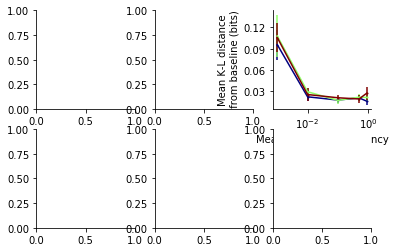

In [14]:
variationType = 'normal'

if variationType == 'normal':
    muList = [0.001,0.01,0.1,0.5,0.9]
    cvList = [0,0.5,1.0]
elif variationType == 'powerLaw':
    muList = [1.0]
    cvList = [-0.999,-0.9,-0.5,0.90,4]

    
muRange = np.zeros_like( cvList )
chemicalPotential = 3

numReps = 10
motifInformation = np.zeros( (len(muList), len(cvList),numReps) )
muIdx = 0

for muExt in muList:
    widthIdx = 0
    for width in cvList:
        if width > 0 and variationType == 'normal':
            pExtChip = distributions.truncNorm( a=0, b=1, mu=muExt, sigma=width*muExt, size=np.int(numLocations) )
        else:
            if variationType == 'normal':
                pExtChip = muExt
            elif variationType == 'powerLaw':
                pExtChip = distributions.truncPowerLawRVs( width, 0, 1, size=np.int(numLocations), algorithm='scipy' )
                muRange[widthIdx] = np.mean( pExtChip )
        
        pExtControl = pExtChip
        print( "{}/{},{}/{}".format( muIdx, len(muList), widthIdx, len(cvList) ) )
        for rep in range(numReps):
            genome = cs.performChipSeq( baselineSequences, baselineEnergies, pExt=pExtChip, 
                                       numCells=100000, chemicalPotential=chemicalPotential ) 

            genome = genome.sort_values(by='ratio',ascending=False)
            learnGenome = genome.head( np.int(0.1*numLocations) )

            pwmSingle, pcmSingle, pfmSingle = cs.findPWM( learnGenome['sequence'].values )
            motifInformation[muIdx,widthIdx,rep] = MotifTable.klDist( pfmRef, pfmSingle )/pfmRef.shape[1]
            
        widthIdx += 1
    muIdx += 1

if variationType == 'normal':
    fig, axes = getPaperFigureHandle('Figure 2')
elif variationType == 'powerLaw':
    fig, axes = getPaperFigureHandle('Figure S2')    
    
ax = axes[0,2]
ax.clear()
plt.sca(ax)

means = motifInformation.mean(axis=2)
stds = motifInformation.std(axis=2)
if variationType == 'normal':
    _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation',xIsMean=True,
                            xAxisText='Mean extraction efficiency', yAxisText='Mean K-L distance\n from baseline (bits)', cmap='jet',fontsize=10, plotCbar=False) 
elif variationType == 'powerLaw':
    ax.errorbar( muRange, means[0], yerr=stds[0], marker='.' )
    ax.set_xlabel('Mean extraction efficiency',fontsize=10)
    ax.set_ylabel('Mean K-L distance\n from baseline (bits)',fontsize=10)

ax.tick_params(labelsize=10)
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
ax.set_xscale('log')


In [16]:
if variationType == 'normal':
    fig, axes = getPaperFigureHandle('Figure 2')
elif variationType == 'powerLaw':
    fig, axes = getPaperFigureHandle('Figure S2')    
    
ax = axes[0,2]
ax.clear()
plt.sca(ax)

means = motifInformation.mean(axis=2)
stds = motifInformation.std(axis=2)
if variationType == 'normal':
    _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation',xIsMean=True,
                            xAxisText='Mean extraction efficiency', yAxisText='Mean K-L distance\n from baseline (bits)', cmap='jet',fontsize=10, plotCbar=False) 
elif variationType == 'powerLaw':
    ax.errorbar( muRange, means[0], yerr=stds[0], marker='.' )
    ax.set_xlabel('Mean extraction efficiency',fontsize=10)
    ax.set_ylabel('Mean K-L distance\n from baseline (bits)',fontsize=10)

ax.tick_params(labelsize=10)
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
ax.set_xscale('log')

## Figure 3A [Top, sample output, indirect binding]

In [ ]:
numLocations = 1000

pExt = distributions.truncNorm( a=0, b=1.0, mu=0.5, sigma=0.05, size=numLocations )

fracIndirect = 0.3
mainTf = 'Tye7'

indirectIdx = 0

directMotif = MotifTable.MotifTable( mainTf )
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
spEnergies, sequences = directMotif.sampleFromDistribution( energiesSampled )

secondTFspEnergies = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
backgroundDf = cs.makeBackgroundSequences( numLocations, mainTf )

indirectLocations = np.arange(int(fracIndirect*numLocations))
chemicalPotential = 3
secondTFchemicalPotential = 3
genome = cs.performChipSeq( spEnergies=spEnergies, secondTFspEnergies=secondTFspEnergies, indirectLocations=indirectLocations,
                          chemicalPotential=chemicalPotential, secondTFchemicalPotential=secondTFchemicalPotential )

fig, axes = getPaperFigureHandle('Figure 3')
ax = axes[0,0]
ax.clear()

genome.loc[:,'ratio'] = genome.eval('unique_chip_reads/unique_control_reads')
directDf = genome.query('binding == "direct"')
indirectDf = genome.query('binding == "indirect"')
ax.scatter( directDf['energy_A'], directDf['ratio'].values, marker='.', label='Direct', s=3 )
ax.scatter( indirectDf['energy_A'], indirectDf['ratio'].values, marker='.', label='Indirect', s=3 )
ax.set_xlabel('Binding energy')
ax.set_ylabel('Read count ratio')
ax.legend() 

ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )

## Figure 3A [Bottom, sample output, cooperative binding]

In [ ]:
numLocations = 1000

pExt = distributions.truncNorm( a=0, b=1.0, mu=0.5, sigma=0.05, size=numLocations )

numCoop = 300
mainTf = 'Tye7'
coopTf = 'Cbf1'
indirectIdx = 0

directMotif = MotifTable.MotifTable( mainTf )
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
spEnergies, sequences = directMotif.sampleFromDistribution( energiesSampled )

coopDf, coopMotifs = cs.makeCoopSequences( numLocations, [mainTf,coopTf], [['powerLaw',0.5,0,10],['powerLaw',0.5,0,10]] ) #This will choose a single random indirectly bound partner
secondSequences = coopDf['sequence_2'].values
secondTFspEnergies = coopDf['sp_energy_2'].values

tfIntEnergies = np.append( np.ones( numCoop )*(-6), np.zeros( numLocations - numCoop ))

chemicalPotential = 3
secondTFchemicalPotential = 3

genome = cs.performChipSeq( spEnergies=spEnergies, secondTFspEnergies=secondTFspEnergies,  secondTFintEnergies=tfIntEnergies,
                          chemicalPotential=chemicalPotential, secondTFchemicalPotential=secondTFchemicalPotential, numCells=10000 )

fig, axes = getPaperFigureHandle('Figure 3')
ax = axes[1,0]
ax.clear()

genome.loc[:,'ratio'] = genome.eval('unique_chip_reads/unique_control_reads')
q = genome['ratio'].quantile( 0.9 )
directDf = genome.query('binding == "direct"')
coopDf = genome.query('binding == "cooperative"')
ax.scatter( directDf['energy_A'], directDf['ratio'].values, marker='.', label='Independent', s=3 )
ax.scatter( coopDf['energy_A'], coopDf['ratio'].values, marker='.', label='Cooperative', s=3 )
ax.set_xlabel('Binding energy')
ax.set_ylabel('Read count ratio')
ax.legend() 

ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
print( scipy.stats.pearsonr( coopDf['energy_A'].values, coopDf['ratio'].values ) )


## Figure 3B [Middle Row, Left, Indirect binding]

In [ ]:
numLocations = 1000

pExt = distributions.truncNorm( a=0, b=1.0, mu=0.5, sigma=0.05, size=numLocations )
numReps = 10

fracIndirectSet = [0.001,0.01,0.1,0.2,0.3,0.4,0.5]
mainTf = 'Tye7'

indirectIdx = 0

directMotif = MotifTable.MotifTable( mainTf )
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
spEnergies, sequences = directMotif.sampleFromDistribution( energiesSampled )

genome = cs.performChipSeq( sequences, spEnergies, pExt=pExt, numCells=100000 )

learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))
pwmRef, pcmRef, pfmRef = cs.findPWM( learnGenome['sequence'].values )

energyRange = [0,10]
lineStyles = ['solid']
colors = ['black']
fig, axes = getPaperFigureHandle( 'Figure 3' )
ax = axes[0,1]
ax.clear()

secondTFspEnergies = distributions.truncPowerLawRVs( 0.5, energyRange[0], energyRange[1], size=numLocations )
backgroundDf = cs.makeBackgroundSequences( numLocations, mainTf )
backgroundSequences = backgroundDf['sequence'].values
motifInformation = np.zeros( (len( fracIndirectSet ), numReps ) )

chemicalPotential = 3
secondTFchemicalPotential = 3

indirectIdx = 0
for fracIndirect in fracIndirectSet:
    numIndirect = np.int( fracIndirect*numLocations )

    indirectLocations = np.arange( numIndirect )

    sequencesToPass = np.copy( sequences )
    sequencesToPass[:numIndirect] = backgroundDf['sequence'].values[:numIndirect]

    for rep in range(numReps):
        print( "{}/{},{}/{} : f = {}".format( indirectIdx+1, len(fracIndirectSet), rep+1, numReps, fracIndirect))
        genome = cs.performChipSeq( sequences, spEnergies, numCells=100000, secondTFspEnergies=secondTFspEnergies, 
                                   indirectLocations=indirectLocations, chemicalPotential=chemicalPotential,  
                                  secondTFchemicalPotential=secondTFchemicalPotential )

        learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))
        pwmDouble, pcmDouble, pfmDouble = cs.findPWM( learnGenome['sequence'].values )
        motifInformation[indirectIdx,rep] = MotifTable.klDist( pfmRef, pfmDouble )/pfmRef.shape[1]
    indirectIdx += 1

ax.errorbar( fracIndirectSet, motifInformation.mean(axis=1), marker='.', color='black', ls=lineStyles[0], yerr=motifInformation.std(axis=1) )
ax.set_xlabel('Fraction indirectly bound',fontsize=10)
#ax.set_ylabel('Mean K-L distance from single motif (bits)',fontsize=10)
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )

In [ ]:
lineStyles = ['solid']
colors = ['black']
fig, axes = getPaperFigureHandle( 'Figure 3' )
ax = axes[0,1]
ax.clear()

ax.errorbar( fracIndirectSet, motifInformation.mean(axis=1), marker='.', color='black', ls=lineStyles[0], yerr=motifInformation.std(axis=1) )
ax.set_xlabel('Fraction indirectly bound',fontsize=10)
#ax.set_ylabel('Mean K-L distance from single motif (bits)',fontsize=10)
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )

## Figure 3B [Cooperatively bound fraction]

In [ ]:
numLocations = 1000

numReps = 10
#fracCoopSet = np.arange( 0.001, 1.0, 0.1 )
fracCoopSet = [0.001,0.01,0.1,0.2,0.3,0.4,0.5]
motifInformation = np.zeros( (len( fracCoopSet ), numReps ) )

coopTf = 'Cbf1'
mainTf = 'Tye7'
intEnergyList = [-6,-2]

directDf, directMotif = cs.makeDirectSequences( numLocations, mainTf, ['powerLaw',0.5,0,10] )
sequences = directDf['sequence'].values
spEnergies = directDf['sp_energy_1'].values
pExt = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations )
genome = cs.performChipSeq( sequences, spEnergies, pExt=pExt )

learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))

pwmSingle, pcmSingle, pfmRef = cs.findPWM( learnGenome['sequence'].values )

energyRange = [0,10]

intEnergyColors = ['black',cbcolors['sky blue']]
fig, axes = getPaperFigureHandle( 'Figure 3' )
ax = axes[0,2]

chemicalPotential = 3
secondTFchemicalPotential = 3

lineStyles = ['solid']
ax.clear()
coopDf, coopMotifs = cs.makeCoopSequences( numLocations, [mainTf,coopTf], [['powerLaw',0.5,0,10],['powerLaw',0.5,energyRange[0],energyRange[1]]] ) #This will choose a single random indirectly bound partner
secondSequences = coopDf['sequence_2'].values
secondTFspEnergies = coopDf['sp_energy_2'].values

intEnergyItr = 0
for intEnergy in intEnergyList:
    motifInformation = np.zeros( (len( fracCoopSet ), numReps ) )
    coopIdx = 0
    for fracCoop in fracCoopSet:
        numCoop = np.int( fracCoop*numLocations )

        coopLocations = np.arange( numCoop )
        tfIntEnergies = np.append( np.ones( numCoop )*intEnergy, np.zeros( numLocations - numCoop ))

        for rep in range(numReps):
            print( "{}/{},{}/{},{}/{}".format( coopIdx+1, len(fracCoopSet), intEnergyItr, len(intEnergyList), rep+1, numReps))

            genome = cs.performChipSeq( sequences, spEnergies, pExt=pExt,secondTFspEnergies=secondTFspEnergies, 
                                       secondTFintEnergies=tfIntEnergies, chemicalPotential=chemicalPotential, 
                                       secondTFchemicalPotential=secondTFchemicalPotential, numCells=100000 )

            learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))

            pwmDouble, pcmDouble, pfmDouble = cs.findPWM( learnGenome['sequence'].values )
            motifInformation[coopIdx,rep] = MotifTable.klDist( pfmRef, pfmDouble )/pfmRef.shape[1]
        coopIdx += 1

    ax.errorbar( fracCoopSet, motifInformation.mean(axis=1), color=intEnergyColors[intEnergyItr], ls=lineStyles[0], yerr=motifInformation.std(axis=1), 
                capthick=2, marker='.', ms=2, label='$\Delta = {}k_BT$'.format(intEnergy) )
    ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
    ax.set_xlabel('Fraction cooperatively bound',fontsize=10)
    axes[0,1].set_ylabel('Mean K-L distance\nfrom baseline (bits)')
    
    intEnergyItr += 1


# False positive simulations (Figure 4)

## Initialization for Figure 4

In [ ]:
numLocations = 1000
numFPlocations = 1000
numLocations += numFPlocations

energiesSampled = np.zeros(numLocations)

energyThreshold = 1.59 #E0, the binding energy of the unbound state
mFold = 10    #This is the occupancy difference between true positive binding sites and 

beta = 0.5
Emax = 6
energiesSampled[:numLocations] = distributions.truncPowerLawRVs( beta, 0, Emax, size=numLocations )
occProbs = 1/ (1 + np.exp( energiesSampled ) )
bgEnergy = getInputEnergy( occProbs, mFold, E0=energyThreshold )

fpMfold = 1.42
fpBeta, fpEmax = getFPpowerLaw( beta, Emax,  fpMfold )
fpEnergies = distributions.truncPowerLawRVs( fpBeta, 0, fpEmax, size=numFPlocations )

energiesSampled[(numLocations-numFPlocations):] = fpEnergies
pExt = distributions.truncNorm( a=0,b=1,mu=0.5,sigma=0.05, size=numLocations)



## Figure 4A [Simulation with false-positives and sample ROC]

In [ ]:
spEnergies = energiesSampled
fig, axes = getPaperFigureHandle( 'Figure 4' )
ax = axes[0,1]
ax.clear()
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

chemicalPotential = 3
numReps = 1
genome = cs.performChipSeq( spEnergies=spEnergies, numFPlocations=numFPlocations, bgEnergy=bgEnergy, pExt=pExt, 
                           chemicalPotential=chemicalPotential, numCells=100000 )

print( 'Mean occupancy ratio between foreground and false positives : {}'.format( genome.query('binding == "direct"')['p_occ_chip'].mean()/genome.query('binding == "false-positive"')['p_occ_chip'].mean() ) )

labels = np.zeros(genome.shape[0],dtype=np.bool)
direct = genome['binding'] == "direct"
labels[direct] = True
labels[~direct] = False
auROC = sklearn.metrics.roc_auc_score( labels, genome['ratio'].values )
fpr, tpr, thresholds = sklearn.metrics.roc_curve( labels, genome['ratio'].values )
ax.plot(fpr, tpr, label='Area under ROC = {:.2f}'.format( auROC ) )
ax.legend()

ax = axes[0,0]
ax.clear()
ax.set_xlabel('Binding energy')
ax.set_ylabel('Read count ratio')

tpDf = genome.query('binding == "direct"')
fpDf = genome.query('binding == "false-positive"')
ax.scatter( tpDf['energy_A'].values, tpDf['ratio'].values, marker='.', s=3, label='True binding sites', alpha=0.75)
ax.scatter( fpDf['energy_A'].values, fpDf['ratio'].values, marker='.', s=3, label='False positives', alpha=0.75 )
ax.legend(fontsize=8)           

## Figure 4B [Extraction heterogeneity impact on auROC]

In [ ]:
spEnergies = energiesSampled
fig, axes = getPaperFigureHandle( 'Figure 4' )
ax = axes[0,2]

ax.clear()
plt.sca( ax )

muList = [0.001,0.01,0.1,0.5,0.9]
cvList = [0,0.5,1.0]

energiesSampled = distributions.truncPowerLawRVs( beta, 0, Emax, size=numLocations )
fpMfoldList = [1.42,2.0]
lineStyleList = ['solid','dashed']

numReps = 10
chemicalPotential = 3
fpItr = 0
for fpMfold in fpMfoldList:
    fpBeta, fpEmax = getFPpowerLaw( beta, Emax,  fpMfold )
    fpEnergies = distributions.truncPowerLawRVs( fpBeta, 0, fpEmax, size=numFPlocations )
    energiesSampled[(numLocations-numFPlocations):] = fpEnergies
    spEnergies = energiesSampled
    
    occProbs = 1/ (1 + np.exp( energiesSampled - energyThreshold - chemicalPotential ) )
    bgEnergy = getInputEnergy( occProbs, mFold, E0=energyThreshold )
    
    auROCmat = np.zeros( (len(muList), len(cvList),numReps) )
        
    muIdx = 0
    for muExt in muList:
        widthIdx = 0
        for width in cvList:
            if width > 0:
                pExtChip = distributions.truncNorm( a=0, b=1, mu=muExt, sigma=width*muExt, size=np.int(numLocations) )
                #pExtChip = powerLaw( width, 0, 1, size=np.int(numLocations) )            
            else:
                pExtChip = muExt

            pExtControl = pExtChip
            print( "{}/{},{}/{}".format( muIdx, len(muList), widthIdx, len(cvList) ) )
            for rep in range(numReps):

                genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExtChip, bgEnergy=bgEnergy, numFPlocations=numFPlocations, 
                                           chemicalPotential=chemicalPotential ) 
                nanInfs = np.isnan( genome['ratio'].values ) | np.isinf( genome['ratio'].values )
                genome = genome.loc[~nanInfs,:]
                genome = genome.query('ratio > 0')


                auROCmat[muIdx,widthIdx,rep] = util.findAuROC( genome )
            widthIdx += 1
        muIdx += 1
    
    means = auROCmat.mean(axis=2)
    stds = auROCmat.std(axis=2)
    _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation',xIsMean=True, ls=lineStyleList[fpItr],
                            xAxisText='Mean extraction efficiency', yAxisText='Area under ROC', cmap='jet',fontsize=10, plotCbar=False )    
    fpItr += 1
ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.grid('on',ls='dashed')
#ax.set_axisbelow(True)

## Figure 4B [Amplification heterogeneity impact on auROC]

In [ ]:
spEnergies = energiesSampled
fig, axes = getPaperFigureHandle( 'Figure 4' )
ax = axes[1,0]
ax.clear()
plt.sca( ax )

energiesSampled = distributions.truncPowerLawRVs( beta, 0, Emax, size=numLocations )
fpMfoldList = [1.42,2.0]
lineStyleList = ['solid','dashed']

fig, axes = getPaperFigureHandle( 'Figure 4' )
ax = axes[1,0]
ax.clear()
plt.sca( ax )

chemicalPotential = 3

muList = [10,100,1000,10000]
cvList = [0.0,0.5,1.0]

numReps = 10
pcrCycles = 15
fpItr = 0
pExtChip = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations )
for fpMfold in fpMfoldList:
    fpBeta, fpEmax = getFPpowerLaw( beta, Emax,  fpMfold )
    fpEnergies = distributions.truncPowerLawRVs( fpBeta, 0, fpEmax, size=numFPlocations )
    energiesSampled[(numLocations-numFPlocations):] = fpEnergies
    spEnergies = energiesSampled    
    auROCmat = np.zeros( (len(muList), len(cvList),numReps) )
    muIdx = 0
    
    for muAmp in muList:
        widthIdx = 0
        for width in cvList:
            if width > 0:
                muAmpWidth = width*muAmp
                ampRatio = distributions.truncNorm( a=1, b=2**pcrCycles, mu=muAmp, sigma=width*muAmp, size=np.int(numLocations) )
            else:
                ampRatio = muAmp

            pExtControl = pExtChip
            print( "{}/{},{}/{}".format( muIdx, len(muList), widthIdx, len(cvList) ) )
            for rep in range(numReps):
                genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExtChip, numFPlocations=numFPlocations, numCells=100000, 
                                           ampRatio=ampRatio, pcrCycles=pcrCycles, bgEnergy=bgEnergy, chemicalPotential=chemicalPotential ) 

                nanInfs = np.isnan( genome['ratio'].values ) | np.isinf( genome['ratio'].values )
                genome = genome.loc[~nanInfs,:]
                genome = genome.query('ratio > 0')
                
                auROCmat[muIdx,widthIdx,rep] = util.findAuROC( genome )
            widthIdx += 1
        muIdx += 1

    means = auROCmat.mean(axis=2)
    stds = auROCmat.std(axis=2)
    _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation',xIsMean=True, ls=lineStyleList[fpItr],
                                xAxisText='Mean amplification efficiency', yAxisText='Area under ROC', cmap='jet',fontsize=10, plotCbar=False )    
    
    fpItr += 1
ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.grid('on',ls='dashed')
#ax.set_axisbelow(True)

## [Figure 4E] F-P occupancy dependence

In [ ]:
numLocations = 1000
numFPlocations = 1000
numLocations += numFPlocations
pExt = distributions.truncNorm( a=0,b=1,mu=0.5,sigma=0.05, size=numLocations)

energiesSampled = distributions.truncPowerLawRVs( beta, 0, Emax, size=numLocations )
fig, axes = getPaperFigureHandle( 'Figure 4' )
ax = axes[1,1]
ax.clear()
plt.sca( ax )
chemicalPotential = 3

fpMfoldList = [1,1.2,1.4,1.6,1.8,2,2.5,3,5]
numReps = 10
pcrCycles = 15
auROCmat = np.zeros( (len(fpMfoldList),numReps) )
meanOccRatio = np.zeros( len(fpMfoldList ) )
mIdx = 0
for fpMfold in fpMfoldList:
    pExtControl = pExtChip
    print( "{}/{}".format( mIdx, len(fpMfoldList) ) )
    fpBeta, fpEmax = getFPpowerLaw( beta, Emax,  fpMfold )
    fpEnergies = distributions.truncPowerLawRVs( fpBeta, 0, fpEmax, size=numFPlocations )

    energiesSampled[(numLocations-numFPlocations):] = fpEnergies
    for rep in range(numReps):
        genome = cs.performChipSeq( spEnergies=energiesSampled, pExt=pExt, numFPlocations=numFPlocations, chemicalPotential=chemicalPotential ) 
        auROCmat[mIdx,rep] = util.findAuROC( genome )
        meanOccRatio[mIdx] = genome.query('binding == "direct"')['p_occ_chip'].mean()/genome.query('binding == "false-positive"')['p_occ_chip'].mean()

    mIdx += 1

ax.errorbar( meanOccRatio, auROCmat.mean(axis=1), yerr=auROCmat.std(axis=1),  marker='.', ms=3 )
ax.set_xscale('log')
ax.set_ylim(0,1)
ax.grid('on',ls='dashed')
ax.set_axisbelow(True)
ax.set_xlabel('Mean occupancy ratio')



## [Figure 4F] Coverage dependence

In [ ]:
numLocations = 1000
numFPlocations = 1000
numLocations += numFPlocations
pExt = distributions.truncNorm( a=0,b=1,mu=0.5,sigma=0.05, size=numLocations)

fig, axes = getPaperFigureHandle( 'Figure 4' )
ax = axes[1,2]
ax.clear()
plt.sca( ax )

chemicalPotential = 3

numReps = 10
pcrCycles = 15
depthList = [10,50,100,500,1000]
fpMfoldList = [1.42,2.0]
lineStyleList = ['solid','dashed']

fpItr = 0
for fpMfold in fpMfoldList:
    fpBeta, fpEmax = getFPpowerLaw( beta, Emax,  fpMfold )
    fpEnergies = distributions.truncPowerLawRVs( fpBeta, 0, fpEmax, size=numFPlocations )
    energiesSampled[(numLocations-numFPlocations):] = fpEnergies
    spEnergies = energiesSampled
    
    auROCmat = np.zeros( (len(depthList),numReps) )
    mIdx = 0
    for depth in depthList:
        print( "{}/{}".format( mIdx+1, len(depthList) ) )
        
        for rep in range(numReps):
            genome = cs.performChipSeq( spEnergies=energiesSampled, depth=depth, pExt=pExtChip, bgEnergy=bgEnergy, numFPlocations=numFPlocations, chemicalPotential=chemicalPotential ) 
            
            nanInfs = np.isnan( genome['ratio'].values ) | np.isinf( genome['ratio'].values )
            genome = genome.loc[~nanInfs,:]
            genome = genome.query('ratio > 0')
            
            auROCmat[mIdx,rep] = util.findAuROC( genome )

        mIdx += 1

    ax.errorbar( depthList, auROCmat.mean(axis=1), yerr=auROCmat.std(axis=1), marker='.', ms=2, ls=lineStyleList[fpItr], color='black' )
    fpItr += 1

ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.grid('on',ls='dashed')
#ax.set_axisbelow(True)
ax.set_xlabel('Sequencing depth')

# ChIP-seq Fidelity dependence on experimental parameters [Figure 2 & 3]

## [Figure 2C] Sample

In [ ]:
numLocations = 1000
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )

spEnergies = energiesSampled

fig, axes = getPaperFigureHandle( 'Figure 2' )
ax = axes[1,0]
ax.clear()

chemicalPotential = 3

numReps = 10
quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]
fidelityMat = {}
for q in quantiles:
    fidelityMat[str(q)] = np.zeros(numReps)

labels = ['0-25','25-50','50-75','75-100','All']

pExt = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations)
for rep in range(numReps):
    print('{}/{}'.format(rep,numReps))
    genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExt, numCells=100000, chemicalPotential=chemicalPotential )
    print("Finished simulation")

    genome.loc[:,'ratio'] = genome.eval('unique_chip_reads/unique_control_reads').values
        
    fidelityValues = util.computeFidelity( genome, quantiles=quantiles )        
    print( fidelityValues )
    qIdx = 0
    for q in quantiles:
        if rep == 0 and qIdx < 4:
            qLow, qHigh = genome['ratio'].quantile(q)
            tempDf = genome.query('ratio > {} & ratio < {}'.format( qLow, qHigh ))
            ax.scatter( tempDf['ratio'].values, tempDf['energy_A'].values, marker='.', s=3, label=labels[qIdx] )   
        fidelityMat[str(q)][rep] = fidelityValues[qIdx]
        qIdx += 1
        


## [Figure 2C] Extraction efficiency

In [ ]:
variationType = 'powerLaw'

if variationType == 'normal':
    muExtList = [0.001,0.01,0.1,0.5,0.9]
    #sigmaRange = [0.01,0.05,0.25,1.0,2,10]    
    sigmaRange = [0,0.5,1.0]
elif variationType == 'powerLaw':
    muExtList = [1.0]
    sigmaRange = [-0.999,-0.9,-0.5,0.90,4]
    #sigmaRange = [0.1,0.5,0.9]
    #sigmaRange = [-0.5]
    
    muRange = np.zeros_like( sigmaRange )
ratioColumn = 'ratio'

numReps = 10
numLocations = 1000

directMotif = MotifTable.MotifTable( 'Tye7' )
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
chemicalPotential = 3

quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]
labels = ['Top 25th percentile','25th - 50th percentile','50th - 75th percentile','75th - 100th percentile','All regions']

fidelityMat = {}
for q in quantiles:
    fidelityMat[str(q)] = np.zeros((len(muExtList),len(sigmaRange),numReps))

muIdx = 0
figtemp, axestemp = plt.subplots( nrows=1, ncols=6, sharex=True, sharey=True )
for mu in muExtList:
    sigmaIdx = 0
    for sigma in sigmaRange:
        if variationType == 'normal':
            if sigma > 0:
                pExt = distributions.truncNorm( a=0.0, b=1.0, mu=mu, sigma=sigma*mu, size=numLocations )
            else:
                pExt = mu
        elif variationType == 'powerLaw':
            pExt = distributions.truncPowerLawRVs( sigma, 0, 1, size=np.int(numLocations), algorithm='scipy' )
            muRange[sigmaIdx] = np.std( pExt )/np.mean( pExt )
            
        repIdx = 0
        for rep in range(numReps):
            print('{},{},{}'.format(muIdx,sigmaIdx,rep))
            if ratioColumn == 'score':
                spEnergies, sequences = directMotif.sampleFromDistribution( energiesSampled )                
                genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExt, numCells=100000, chemicalPotential=chemicalPotential )
            else:
                genome = cs.performChipSeq( spEnergies=energiesSampled, pExt=pExt, numCells=100000, chemicalPotential=chemicalPotential )                

            if ratioColumn == 'score':
                genome.loc[:,'ratio'] = genome.eval('unique_chip_reads/unique_control_reads').values

                learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))

                pwmDouble, pcmDouble, pfmDouble = cs.findPWM( learnGenome['sequence'].values )
                calculatedMotif = MotifTable.MotifTable( 'Tye7', 'yeast', pwmDouble, matType='frequencies')
                scores = calculatedMotif.getInformation( genome['sequence'].values )
                genome.loc[:,'score'] = scores
            
            qIdx = 0
            fidelityValues = util.computeFidelity( genome, ratioColumn=ratioColumn, minPairs=1000 )
            for q in quantiles[:-1]:
                fidelityMat[str(q)][muIdx,sigmaIdx,rep] = fidelityValues[qIdx]
                qIdx += 1
               
        sigmaIdx += 1
    muIdx += 1


In [ ]:
idx = 0
if variationType == 'normal':
    fig, axes = getPaperFigureHandle('Figure 2')
elif variationType == 'powerLaw':
    fig, axes = getPaperFigureHandle('Figure S2')    

ax = axes[1,2]
ax.clear()
plt.sca(ax)
lineStyles = ['dotted','dashed','solid']
lIdx = 0
for q in quantiles:
    means = fidelityMat[str(q)].mean(axis=2)
    stds = fidelityMat[str(q)].std(axis=2)
   

    if variationType == 'normal':
        if idx in [0,3,4]:
            print( q )
            print( means )
            _ = plots.manyErrorBarsPlot( muExtList, means, stds, sigmaRange, cbarText='Coefficienct of variation',xIsMean=True,ls=lineStyles[lIdx],
                            xAxisText='Mean extraction efficiency', yAxisText='Fidelity', cmap='jet', fontsize=10, plotCbar=False )    
            lIdx += 1
            ax.legend()
            ax.tick_params(labelsize=10)
    elif variationType == 'powerLaw':
        if idx in [0,3,4]:
            ax.errorbar( muRange, means[0], yerr=stds[0], marker='.', label=labels[idx] )
            ax.set_xlabel('Mean extraction efficiency',fontsize=10)
            ax.set_ylabel('Fidelity',fontsize=10)
            ax.legend()
    
    ax.set_ylim([0,1])
    ax.set_xscale('log')
    idx += 1

ax.legend()

## [Figure 2C] PCR amplification efficiency

In [ ]:
variationType = 'powerLaw'

if variationType == 'normal':
    muAmpList = [10,100,1000,10000]
    sigmaRange = [0.0,0.5,1.0]
elif variationType == 'powerLaw':
    muAmpList = [1.0]
    sigmaRange = [-0.90,-0.5,-0.1,0.8,4]
#    muRange = np.zeros_like( sigmaRange )

ratioColumn = 'ratio'

numReps = 10

quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]
labels = ['Bottom 25','25th - 50th percentile','50th - 75th percentile','Top 25','All regions']
fidelityMat = {}
for q in quantiles:
    fidelityMat[str(q)] = np.zeros((len(muAmpList),len(sigmaRange),numReps))

directMotif = MotifTable.MotifTable( 'Tye7' )
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
chemicalPotential = 3
    
muIdx = 0
ctr = 0
pcrCycles = 15
pExt = distributions.truncNorm( a=0.0, b=1.0, mu=0.5, sigma=0.05, size=numLocations )
for mu in muAmpList:
    sigmaIdx = 0
    for sigma in sigmaRange:
        if variationType == 'normal':
            if sigma > 0:
                ampRatio = distributions.truncNorm( a=1, b=2**pcrCycles, mu=mu, sigma=sigma*mu, size=np.int(numLocations) )                
            else:
                ampRatio = mu
        elif variationType == 'powerLaw':
            pAmp = distributions.truncPowerLawRVs( sigma, 1, 100, size=numLocations, algorithm='scipy' )/100
            ampRatio = np.power( 1 + pAmp, pcrCycles )

            muRange[sigmaIdx] = np.mean( ampRatio )
        
        repIdx = 0
        for rep in range(numReps):
            print('{},{},{}'.format(muIdx,sigmaIdx,rep))
            if ratioColumn == 'score':
                spEnergies, sequences = directMotif.sampleFromDistribution( energiesSampled )                
                genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExt, numCells=100000, chemicalPotential=chemicalPotential )
            else:
                genome = cs.performChipSeq( spEnergies=energiesSampled, pExt=pExt, numCells=100000, chemicalPotential=chemicalPotential )                

                                    
            if ratioColumn == 'score':
                genome = genome.query('ratio > 0 & unique_control_reads > 0')
                learnGenome = genome.query( 'ratio > {}'.format( genome['ratio'].quantile(0.9)) )

                pwmDouble, pcmDouble, pfmDouble = cs.findPWM( learnGenome['sequence'].values )
                calculatedMotif = MotifTable.MotifTable( 'Tye7', 'yeast', pwmDouble, matType='frequencies')
                scores = calculatedMotif.getInformation( genome['sequence'].values )
                genome.loc[:,'score'] = scores

            #genome.loc[:,'ratio'] = genome.eval('unique_chip_reads/unique_control_reads').values
                
            fidelityValues = util.computeFidelity( genome, ratioColumn=ratioColumn )
            qIdx = 0
            for q in quantiles:
                fidelityMat[str(q)][muIdx,sigmaIdx,rep] = fidelityValues[qIdx]
                qIdx += 1

            repIdx += 1
        sigmaIdx += 1
    muIdx += 1

idx = 0
if variationType == 'normal':
    fig, axes = getPaperFigureHandle('Figure 2')
elif variationType == 'powerLaw':
    fig, axes = getPaperFigureHandle('Figure S2')    
    
ax1 = axes[1,1]
#ax2 = axes[1,2]
ax1.clear()
plt.sca(ax1)
lineStyles = ['dotted','dashed','solid']
lIdx = 0
for q in quantiles:
    means = fidelityMat[str(q)].mean(axis=2)
    stds = fidelityMat[str(q)].std(axis=2)

    if variationType == 'normal':
        if idx in [0,1,2,3,4]:
            ax = ax1
            _ = plots.manyErrorBarsPlot( muAmpList, means, stds, sigmaRange, cbarText='Coefficienct of variation',xIsMean=True,ls=lineStyles[lIdx],
                            xAxisText='Mean amplification ratio', yAxisText='Fidelity', cmap='jet',fontsize=10, plotCbar=False )    
            lIdx += 1
            ax.tick_params(labelsize=10)
    elif variationType == 'powerLaw':
        ax1.errorbar( muRange, means[0], yerr=stds[0], marker='.', label=labels[idx] )
        ax1.set_xlabel('Mean amplification ratio',fontsize=10)
        ax1.set_ylabel('Fidelity',fontsize=10)
    
    ax1.set_ylim([0,1])
    ax1.set_xscale('log')
    idx += 1




In [ ]:
idx = 0
quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]

if ratioColumn == 'ratio':
    fig, axes = getPaperFigureHandle( 'Figure 2' )
else:
    fig, axes = getPaperFigureHandle( 'Figure S2' )
ax = axes[1,1]
#ax2 = axes[1,2]
ax.clear()
plt.sca(ax)
lineStyles = ['dotted','dashed','solid']
lIdx = 0
for q in quantiles:
    means = fidelityMat[str(q)].mean(axis=2)
    stds = fidelityMat[str(q)].std(axis=2)

    if variationType == 'normal':
        if idx in [0,3,4]:
            _ = plots.manyErrorBarsPlot( muAmpList, means, stds, sigmaRange, cbarText='Coefficienct of variation',xIsMean=True,ls=lineStyles[lIdx],
                            xAxisText='Mean amplification ratio', yAxisText='Fidelity', cmap='jet',fontsize=10, plotCbar=False )    
            lIdx += 1
            ax.tick_params(labelsize=10)
    elif variationType == 'powerLaw':
        if idx in [0,3,4]:
            ax.errorbar( muRange, means[0], yerr=stds[0], marker='.', label=labels[idx] )
            ax.set_xlabel('Mean amplification ratio',fontsize=10)
            ax.set_ylabel('Fidelity',fontsize=10)
    
    ax.set_ylim([0,1])
    ax.set_xscale('log')
    idx += 1

## [Figure 3C] Indirect binding

In [ ]:
numLocations = 1000

pExt = distributions.truncNorm( a=0.0, b=1.0, mu=0.5, sigma=0.05, size=numLocations )
numReps = 10

energyRanges = [[0,10]]
fracIndirectSet = [0.001,0.01,0.1,0.2,0.3,0.4,0.5]

quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]
toPlot = [True,False,False,True,True]
labels = ['0-25','25-50','50-75','75-100','All regions']
fidelityMat = {}
for q in quantiles:
    fidelityMat[str(q)] = np.zeros((len(energyRanges),len(fracIndirectSet),numReps))
    
energyIdx = 0

ratioColumn = 'ratio'
chemicalPotential = 3
secondTFchemicalPotential = 3
spEnergies = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )

for energyRange in energyRanges:
    fracIdx = 0
    motifInformation = np.zeros( (len( fracIndirectSet ), numReps ) )    

    secondTFspEnergies = distributions.truncPowerLawRVs( 0.5, energyRange[0], energyRange[1], size=numLocations )

    for fracIndirect in fracIndirectSet:
        numIndirect = np.int( fracIndirect*numLocations )

        indirectLocations = np.arange( numIndirect )

        for rep in range(numReps):
            print( '{},{},{}'.format( energyIdx+1, fracIdx+1, rep+1))

            if ratioColumn == 'score':
                directMotif = MotifTable.MotifTable( 'Tye7', 'yeast' )
                energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )
                spEnergies, sequences = directMotif.sampleFromDistribution( 'yeast', energiesSampled )
                
                genome = cs.performChipSeq( sequences, spEnergies=spEnergies, pExt=pExt, secondTFspEnergies=secondTFspEnergies,
                                           indirectLocations=indirectLocations, numCells=100000, chemicalPotential=chemicalPotential,
                                          secondTFchemicalPotential=secondTFchemicalPotential )                
                
                learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))
      
                pwmDouble, pcmDouble, pfmDouble = cs.findPWM( learnGenome['sequence'].values )
                calculatedMotif = MotifTable.MotifTable( 'Tye7', 'yeast', pwmDouble, matType='frequencies')
                scores = calculatedMotif.getInformation( genome['sequence'].values )
                genome.loc[:,'score'] = scores 
            elif ratioColumn == 'ratio':
                genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExt, secondTFspEnergies=secondTFspEnergies, 
                                           indirectLocations=indirectLocations, numCells=100000, chemicalPotential=chemicalPotential,
                                          secondTFchemicalPotential=secondTFchemicalPotential )
                

            fidelityValues = util.computeFidelity( genome, ratioColumn=ratioColumn )
            qIdx = 0
            for q in quantiles:
                fidelityMat[str(q)][energyIdx,fracIdx,rep] = fidelityValues[qIdx]
                qIdx += 1
                
            for ax in axes.ravel():
                ax.set_xlabel('Binding energy')
                ax.set_ylabel('Read count ratio')
                ax.set_yscale('log')
        fracIdx += 1
    energyIdx += 1

if ratioColumn == 'ratio':
    fig, axes = getPaperFigureHandle( 'Figure 3' )
    ax = axes[1,1]
else:
    fig, axes = getPaperFigureHandle( 'Figure 5' )
    ax = axes[0,1]

ax.clear()
idx = 0
linestyles = ['solid','dashed']
colors = ['black',cbcolors['sky blue'],'orange']
colorIdx = 0
incrementColor = False
for q in quantiles:
    lineIdx = 0
    for energyIdx in range(len(energyRanges)):
        if toPlot[idx]:
            means = fidelityMat[str(q)][energyIdx].mean(axis=1)
            stds = fidelityMat[str(q)][energyIdx].std(axis=1)
            ax.errorbar( fracIndirectSet, means, yerr=stds, color=colors[colorIdx], ls=linestyles[lineIdx], ms=2, marker='.' )
            ax.set_xlabel('Fraction of indirectly bound sites')
            ax.legend()
            ax.set_ylim(0,1)
            incrementColor = True
        lineIdx += 1
    if incrementColor:
        colorIdx += 1
        incrementColor = False
    idx += 1


In [ ]:
if ratioColumn == 'ratio':
    fig, axes = getPaperFigureHandle( 'Figure 2' )
    ax = axes[1,1]
else:
    fig, axes = getPaperFigureHandle( 'Figure 5' )
    ax = axes[0,1]
ax.clear()
idx = 0
linestyles = ['solid','dashed']
colors = ['black',cbcolors['sky blue'],'orange']
colorIdx = 0
incrementColor = False
for q in quantiles:
    lineIdx = 0
    for energyIdx in range(len(energyRanges)):
        if toPlot[idx]:
            means = fidelityMat[str(q)][energyIdx].mean(axis=1)
            stds = fidelityMat[str(q)][energyIdx].std(axis=1)
            ax.errorbar( fracIndirectSet, means, yerr=stds, capthick=2, color=colors[colorIdx], ls=linestyles[lineIdx], ms=2, label=str(energyRanges[energyIdx]), marker='.' )
            
            ax.set_ylim(0,1)
            incrementColor = True
        lineIdx += 1
    if incrementColor:
        colorIdx += 1
        incrementColor = False
    idx += 1
    


## [Figure 3C] Cooperative binding

In [ ]:
fidelityMat = {}

energyRanges = [[0,10]]
labels = [",".join( [str(energy) for energy in bounds]) for bounds in energyRanges]
fracCoopSet = [0.001,0.01,0.1,0.2,0.3,0.4,0.5]
coopTf = 'Atf1'
numReps = 10
ratioColumn = 'ratio'

quantiles = [[0,0.25],[0.25,0.5],[0.5,0.75],[0.75,1.0],[0,1.0]]
toPlot = [True,False,False,True,True]
labels = ['Top 25th percentile','25th - 50th percentile','50th - 75th percentile','75th - 100th percentile','All regions']
fidelityMat = {}
    
pExt = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations )
energyIdx = 0
intEnergies = [-6,-2]

directMotif = MotifTable.MotifTable( 'Tye7','yeast' )
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )

chemicalPotential = 3
secondTFchemicalPotential = 3

for q in quantiles:
    fidelityMat[str(q)] = np.zeros((len(energyRanges),len(intEnergies),len(fracCoopSet),numReps))

for energyRange in energyRanges:
    fracIdx = 0
    secondTFspEnergies = distributions.truncPowerLawRVs( 0.5, energyRange[0], energyRange[1], size=numLocations )    
    
    intEnergyIdx = 0
    for intEnergy in intEnergies:
        fracIdx = 0
        for fracCoop in fracCoopSet:
            numCoopLocations = np.int( fracCoop*numLocations )

            coopLocations = np.arange( numCoopLocations )

            tfIntEnergies = np.append( np.ones( numCoopLocations)*intEnergy, np.zeros( numLocations - numCoopLocations ))

            for rep in range(numReps):
                print( '{}/{},{}/{},{}/{},{}/{}'.format( energyIdx+1, len(energyRanges), intEnergyIdx+1, len( intEnergies), fracIdx+1, len(fracCoopSet), rep+1, numReps))
                if ratioColumn == 'ratio':
                    genome = cs.performChipSeq( spEnergies=spEnergies, pExt=pExt, 
                                           secondTFspEnergies=secondTFspEnergies, secondTFintEnergies=tfIntEnergies, 
                                           chemicalPotential=chemicalPotential, secondTFchemicalPotential=secondTFchemicalPotential, numCells=100000 )
                
                elif ratioColumn == 'score':
                    spEnergies, sequences = directMotif.sampleFromDistribution( energiesSampled )                    
                    genome = cs.performChipSeq( sequences, spEnergies=spEnergies, pExt=pExt, 
                                           secondTFspEnergies=secondTFspEnergies, secondTFintEnergies=tfIntEnergies, 
                                           chemicalPotential=chemicalPotential, secondTFchemicalPotential=secondTFchemicalPotential, numCells=100000 )
                    
                    learnGenome = genome.sort_values(by='ratio',ascending=False).head(np.int(0.1*numLocations))
          
                    pwmDouble, pcmDouble, pfmDouble = cs.findPWM( learnGenome['sequence'].values )
                    calculatedMotif = MotifTable.MotifTable( 'Tye7', 'yeast', pwmDouble, matType='frequencies')
                    scores = calculatedMotif.getInformation( genome['sequence'].values )
                    genome.loc[:,'score'] = scores                

                qIdx = 0
                fidelityValues = util.computeFidelity( genome, ratioColumn=ratioColumn )
                for q in quantiles:
                    fidelityMat[str(q)][energyIdx,intEnergyIdx,fracIdx,rep] = fidelityValues[qIdx]
                    qIdx += 1

            fracIdx += 1
        intEnergyIdx += 1
    energyIdx += 1

if ratioColumn == 'ratio':
    fig, axes = getPaperFigureHandle( 'Figure 3' )
    ax = axes[1,2]
else:
    fig, axes = getPaperFigureHandle( 'Figure 5' )
    ax = axes[0,2]

ax.clear()
idx = 0
linestyles = ['solid','dashed']
colors = ['black',cbcolors['sky blue'],'orange']
colorIdx = 0
incrementColor = False
for q in quantiles:
    lineIdx = 0
    for energyIdx in range(len(energyRanges)):
        if toPlot[idx]:
            means = fidelityMat[str(q)][energyIdx,0].mean(axis=1)
            stds = fidelityMat[str(q)][energyIdx,0].std(axis=1)
            ax.errorbar( fracCoopSet, means, yerr=stds, capthick=2, color=colors[colorIdx], ls=linestyles[lineIdx], ms=2, label=str(energyRanges[energyIdx]), marker='.' )
            ax.set_xlabel('Fraction of cooperatively bound sites')
            ax.set_ylim(0,1)
            incrementColor = True
        lineIdx += 1
    if incrementColor:
        colorIdx += 1
        incrementColor = False
    idx += 1


In [ ]:
if ratioColumn == 'ratio':
    fig, axes = getPaperFigureHandle( 'Figure 3' )
    ax = axes[1,2]
else:
    fig, axes = getPaperFigureHandle( 'Figure 5' )
    ax = axes[0,2]

ax.clear()
idx = 0
linestyles = ['solid','dashed']
colors = ['black',cbcolors['sky blue'],'orange']
colorIdx = 0
incrementColor = False
for q in quantiles:
    lineIdx = 0
    for energyIdx in range(len(energyRanges)):
        if toPlot[idx]:
            means = fidelityMat[str(q)][energyIdx,0].mean(axis=1)
            stds = fidelityMat[str(q)][energyIdx,0].std(axis=1)
            ax.errorbar( fracCoopSet, means, yerr=stds, capthick=2, color=colors[colorIdx], ls=linestyles[lineIdx], ms=2, label=str(energyRanges[energyIdx]), marker='.' )
            ax.set_xlabel('Fraction of cooperatively bound sites')
            ax.set_ylim(0,1)
            incrementColor = True
        lineIdx += 1
    if incrementColor:
        colorIdx += 1
        incrementColor = False
    idx += 1

# Chromatin accessibility [Supplement]

## Area under ROC

In [ ]:
alphaList = [0.1,0.5,1.0,5.0,10,100]
numReps = 10

auROCmat = np.zeros( (len(alphaList),numReps) )
numFPlocations = 1000
numLocations = 1000
numLocations += numFPlocations

beta = 0.5
Emax = 10
energiesSampled = distributions.truncPowerLawRVs( beta, 0, Emax, size=numLocations )
lineStyleList = ['solid','dashed']
fpMfold = 1.37
fpBeta, fpEmax = getFPpowerLaw( beta, Emax,  fpMfold )
fpEnergies = distributions.truncPowerLawRVs( fpBeta, 0, fpEmax, size=numFPlocations )
energiesSampled[(numLocations-numFPlocations):] = fpEnergies

fig, axes = getPaperFigureHandle( 'Figure 5' )
ax = axes[1,0]
axes[1,1].clear()
ax.clear()
plt.sca( ax )

fpItr = 0
alphaIdx = 0
meanAccessibility = []
chemicalPotential = 3
stdAccessibility = []
for alpha in alphaList:
    accessibility = cs.sampleAccessibility( alpha, numSamples=numLocations )
    meanAccessibility.append( np.mean( accessibility ) )
    stdAccessibility.append( np.std( accessibility ) )
    if alpha in [0.5,5.0,10]:
        pd.Series( accessibility ).plot( kind='kde', ax=axes[1,1] , label='$\\alpha =$ {}'.format( alpha ) )
    print( "{}/{}".format(  alphaIdx, len(alphaList) ) )
    axes[1,1].set_xlim(0,1)
    for rep in range(numReps):
        genome = cs.performChipSeq( spEnergies=energiesSampled, numFPlocations=numFPlocations, numCells=100000, chemicalPotential=chemicalPotential, chromAccessibility=accessibility ) 

        auROCmat[alphaIdx,rep] = util.findAuROC( genome )
    alphaIdx += 1

means = auROCmat.mean(axis=1)
stds = auROCmat.std(axis=1)
ax.errorbar( meanAccessibility, means, yerr=stds, marker='o' )
ax = plt.gca()
ax.set_xlabel('Mean accessbility')
ax.set_ylabel('Area under ROC')

ax.set_xscale('log')
ax.set_ylim(0,1)

axes[1,1].set_xlabel('Accesibility')
axes[1,1].legend()
ax.grid('on',ls='dashed')
ax.set_axisbelow(True)



# Estimated number of replicates needed to infer from ChIP-seq data [Figure 5]

## Plotting results for number of replicates needed for binding energy

In [ ]:
#cs.singleTFmain(prior='powerLaw',maxReplicates=4,priorParams=[0.5,0,10], makePlot=True)

import pickle
numLocations = 1000
kdeReplicates = 1000
distInfo = ['powerLaw', 0.5, 0, 10]
numTFs = 1
prior = 'powerLaw'
chemicalPotential = 3
dictFileName = cs.os.path.join( 'data', 'posteriorData-N{}-K{}-distInfo-{}-numTFs-{}-prior{}-mu{}.pickle'.format( numLocations, kdeReplicates, str(distInfo), numTFs, prior, chemicalPotential ) )
file = open(dictFileName,'rb')
dictToLoad = pickle.load( file )
file.close()

energies = dictToLoad.keys()
ax = plt.gca()
ax.clear()
for atRepNumber in [1,2,3,4,5]:
    avgIntervalWidths = []
    avgIntervalStds = []
    
    for key in dictToLoad.keys():
        energy = key
        intervalSet = dictToLoad[key]
        tempIntervals = []
        for intervals in intervalSet:
            numReps = 1
            for interval in intervals:
                if numReps == atRepNumber:
                    tempIntervals.append( interval[1] - interval[0] )
                    break
                numReps += 1

        avgIntervalWidths.append( np.mean(tempIntervals) )
        avgIntervalStds.append( np.std(tempIntervals) )

    plt.errorbar( list(energies), avgIntervalWidths, yerr=avgIntervalStds, marker='o', ms=4, label='After replicate {}'.format( atRepNumber ) )        
    
ax = plt.gca()
ax.set_axisbelow(True)
ax.plot( [2,6], [0.71,0.71], color='red', ls='dashed', linewidth=2 )
ax.plot( [2,6], [0.24,0.24], color='red', ls='dashed', linewidth=2 )

ax.legend()
ax.set_xlabel('Binding Energy ($k_BT$)',fontsize=10)
ax.set_ylabel('Absolute uncertainty ($k_BT$)',fontsize=10)


## Computing distribution of energy differences between two single-site variants of a binding site sequence

Note : To run this block of code, download binding enery matrices from http://stormo.wustl.edu/TF-BEMs/Mono-Nuc-Models.tar.gz (last accessed 03 October 2018). 
On extraction, the required energy matrices will be present in the `BEM_models/` folder. Copy all the energy matrices in this folder into the `./data/pbm_pwms/` directory. 

The individual BEMs are in the following format (shown here is the BEM for Aft1) ---

```
1: -0.12 0.03 -0.12 0.22
2: -0.00 0.07 -0.20 0.14
3: -0.08 0.03 0.04 0.00
4: -0.07 -0.04 -0.23 0.34
5: -0.10 0.01 -0.10 0.20
6: -0.11 0.06 -0.08 0.13
7: -0.21 0.04 0.12 0.06
8: -0.53 0.35 0.01 0.17
9: -0.73 0.39 0.18 0.17
10: 0.86 -0.34 -0.18 -0.34
```

Since the ```loadMotif()``` function in ```MotifTable.py``` is suited for this input format, it will not work if the file formats on the URL above are changed.

In [ ]:
tfList = ["AFT1", "ALX3", "ALX4", "ARID3A", "ARID5A", "ARO80", "ARX", "ASCL2", "ASG1", "ATF1", "BAPX1", "BARHL1", "BARHL2", "BARX1", "BARX2", "BAS1", "BBX", "BCL6B", "BHLHB2", "BSX", "CART1", "CBF1", "CDX1", "CDX2", "CEH", "CEP3", "CHA4", "CPHX", "CRX", "CUP9", "CUTL1", "DBX1", "DBX2", "DLX1", "DLX2", "DLX3", "DLX4", "DLX5", "DMBX1", "DOBOX4", "DOBOX5", "DUXL", "E2F", "ECM22", "EGR1", "EHF", "ELF2", "ELF3", "ELF4", "ELF5", "ELK1", "ELK3", "ELK4", "EMX2", "EN1", "EN2", "EOMES", "ERG", "ESRRA", "ESX1", "ETS1", "ETV1", "ETV3", "ETV4", "ETV5", "ETV6", "EVX1", "EVX2", "FHL1", "FKH1", "FKH2", "FLI1", "FOXA2", "FOXJ1", "FOXJ3", "FOXK1", "FOXL1", "GABPA", "GAL4", "GAT1", "GAT3", "GAT4", "GATA3", "GATA5", "GATA6", "GBX1", "GBX2", "GCM1", "GCN4", "GLIS2", "GLN3", "GM397", "GM4881", "GM5454", "GMEB1", "GSC", "GSH2", "GSM1", "GZF3", "HAL9", "HBP1", "HDX", "HIC1", "HLH", "HLX1", "HLXB9", "HMBOX1", "HMX1", "HMX2", "HMX3", "HNF4A", "HOMEZ", "HOXA1", "HOXA10", "HOXA11", "HOXA13", "HOXA2", "HOXA3", "HOXA4", "HOXA5", "HOXA6", "HOXA7", "HOXA9", "HOXB13", "HOXB3", "HOXB4", "HOXB5", "HOXB6", "HOXB7", "HOXB8", "HOXB9", "HOXC10", "HOXC11", "HOXC12", "HOXC13", "HOXC4", "HOXC5", "HOXC6", "HOXC8", "HOXC9", "HOXD1", "HOXD10", "HOXD11", "HOXD12", "HOXD13", "HOXD3", "HOXD8", "IPF1", "IRC", "IRF3", "IRF4", "IRF5", "IRF6", "IRX2", "IRX3", "IRX4", "IRX5", "IRX6", "ISGF3G", "ISL2", "ISX", "JUNDM2", "KLF7", "LBX2", "LEF1", "LEU3", "LHX1", "LHX2", "LHX3", "LHX4", "LHX5", "LHX6", "LHX8", "LHX9", "LMX1A", "LMX1B", "LYS14", "MAFB", "MAFK", "MATALPHA2", "MAX", "MBP1", "MCM1", "MEIS1", "MEOX1", "MET32", "MGA1", "MIG1", "MIG2", "MIG3", "MRG1", "MRG2", "MSX1", "MSX2", "MSX3", "MTF1", "MXL", "MYB", "MYBL1", "MYF6", "NDT80", "NHP6A", "NHP6B", "NKX1", "NKX2", "NKX3", "NKX6", "NR2F", "NRG1", "NSY", "OAF1", "OBOX1", "OBOX2", "OBOX3", "OBOX5", "OBOX6", "OCT", "OG2X", "OSR1", "OSR2", "OTP", "OTX1", "OTX2", "PAX4", "PAX6", "PAX7", "PBF1", "PBF2", "PBX1", "PDR1", "PHD1", "PHO2", "PHO4", "PHOX2A", "PHOX2B", "PITX1", "PITX2", "PITX3", "PKNOX1", "PKNOX2", "PLAGL1", "POU1F", "POU2F", "POU3F", "POU4F", "POU6F", "PROP1", "PRRX1", "PRRX2", "PUT3", "RAP1", "RARA", "RAX", "RDR1", "RDS1", "RDS2", "REF", "RFX3", "RFX4", "RFXDC2", "RGT1", "RHOX11", "RHOX6", "RPH1", "RPN4", "RSC3", "RSC30", "RTG3", "RXRA", "SFL1", "SFP1", "SFPI1", "SHOX2", "SIP4", "SIX1", "SIX2", "SIX3", "SIX4", "SIX6", "SKN7", "SMAD3", "SMP1", "SOX1", "SOX11", "SOX12", "SOX13", "SOX14", "SOX15", "SOX17", "SOX18", "SOX21", "SOX30", "SOX4", "SOX5", "SOX7", "SOX8", "SP100", "SP4", "SPDEF", "SPIC", "SPT15", "SRD1", "SRF", "SRY", "STB3", "STP2", "STP4", "SUM1", "SUT2", "TBF1", "TBP", "TBS1", "TCF1", "TCF2", "TCF3", "TCF7", "TCF7L", "TCFAP2A", "TCFAP2B", "TCFAP2C", "TCFAP2E", "TCFE2A", "TEA1", "TEC1", "TGIF1", "TGIF2", "TITF1", "TLX2", "TYE7", "UME6", "UNCX4", "USV1", "VAX1", "VAX2", "VSX1", "XBP1", "YAP1", "YAP6", "YBR239C", "YDR520C", "YER130C", "YGR067C", "YKL222C", "YLL054C", "YML081W", "YNR063W", "YOX1", "YPR013C", "YPR015C", "YPR196W", "YRM1", "YRR1", "ZBTB12", "ZBTB3", "ZBTB7B", "ZFP105", "ZFP128", "ZFP161", "ZFP187", "ZFP281", "ZFP410", "ZFP691", "ZFP740", "ZIC1", "ZIC2", "ZIC3", "ZIF268", "ZSCAN4"]

seqToNum = {'A' : 0,'C':1,'G':2,'T':3}
siteVariants = [0,1,2,3,0,1,2,3]
positions = np.arange(10) #Length of PWMs from BEEML

energies = [2,3,4,5,6]

energyDiffDict = {}
for energy in energies:
    energyDiffDict[energy] = []
    
tfIdx = 0
for tf in tfList:
    motif = MotifTable.MotifTable( tf )
    skipTf = False

    print( '{}/{}'.format( tfIdx+1, len(tfList)) )
    for energy in energies:
        samples = np.ones(1)*energy
        spEnergies, sequences = motif.sampleFromDistribution( samples )
        
        if len( sequences ) == 0:
            skipTf = True
            break
            
        intSequences = []
        for seq in sequences:
            intSequences.append( [seqToNum[base] for base in seq] )

        mutSites = np.arange(len(sequences[0]))
        energyDiff = 0
        numEnergyDifferences = len( intSequences ) * motif.pwm.shape[1] * 3         
        energyDifferences = np.zeros( numEnergyDifferences ) - 1
        idx = 0
        for intSeq in intSequences:
            for (pos,site) in zip(positions,intSeq):
                baseEnergy = motif.pwm[site,pos]
                mutantBases = siteVariants[(site+1):(site+4)]
                energyDifferences[idx:(idx+3)] = abs(baseEnergy - motif.pwm[mutantBases,pos])
                idx += 3
        
        energyDiffDict[energy] = np.append( energyDiffDict[energy], energyDifferences )
    tfIdx += 1

for energy in energies:
    print("Energy differences of single site mutants from a binding site whose energy is {}k_BT".format( energy ) )
    print( pd.Series( energyDiffDict[energy] ).quantile( [0.025,0.125,0.25]) )
    print("------")


# [Supplement] Compute K-L distance of motif due to extraction and PCR efficiency changes for different TFs

## Sample TFs from different classes

Run the snippet below after downloading the BEEML energy matrices into the `data/pbm_pwms/` folder. This snippet creates a CSV file `tf-energyLimits.csv` in the `data/` folder. This table contains the binding energies of the highest and lowest affinity sites of each TF in the BEEML collection.

In [4]:
tfList = ["AFT1", "ALX3", "ALX4", "ARID3A", "ARID5A", "ARO80", "ARX", "ASCL2", "ASG1", "ATF1", "BAPX1", "BARHL1", "BARHL2", "BARX1", "BARX2", "BAS1", "BBX", "BCL6B", "BHLHB2", "BSX", "CART1", "CBF1", "CDX1", "CDX2", "CEH", "CEP3", "CHA4", "CPHX", "CRX", "CUP9", "CUTL1", "DBX1", "DBX2", "DLX1", "DLX2", "DLX3", "DLX4", "DLX5", "DMBX1", "DOBOX4", "DOBOX5", "DUXL", "E2F", "ECM22", "EGR1", "EHF", "ELF2", "ELF3", "ELF4", "ELF5", "ELK1", "ELK3", "ELK4", "EMX2", "EN1", "EN2", "EOMES", "ERG", "ESRRA", "ESX1", "ETS1", "ETV1", "ETV3", "ETV4", "ETV5", "ETV6", "EVX1", "EVX2", "FHL1", "FKH1", "FKH2", "FLI1", "FOXA2", "FOXJ1", "FOXJ3", "FOXK1", "FOXL1", "GABPA", "GAL4", "GAT1", "GAT3", "GAT4", "GATA3", "GATA5", "GATA6", "GBX1", "GBX2", "GCM1", "GCN4", "GLIS2", "GLN3", "GM397", "GM4881", "GM5454", "GMEB1", "GSC", "GSH2", "GSM1", "GZF3", "HAL9", "HBP1", "HDX", "HIC1", "HLH", "HLX1", "HLXB9", "HMBOX1", "HMX1", "HMX2", "HMX3", "HNF4A", "HOMEZ", "HOXA1", "HOXA10", "HOXA11", "HOXA13", "HOXA2", "HOXA3", "HOXA4", "HOXA5", "HOXA6", "HOXA7", "HOXA9", "HOXB13", "HOXB3", "HOXB4", "HOXB5", "HOXB6", "HOXB7", "HOXB8", "HOXB9", "HOXC10", "HOXC11", "HOXC12", "HOXC13", "HOXC4", "HOXC5", "HOXC6", "HOXC8", "HOXC9", "HOXD1", "HOXD10", "HOXD11", "HOXD12", "HOXD13", "HOXD3", "HOXD8", "IPF1", "IRC", "IRF3", "IRF4", "IRF5", "IRF6", "IRX2", "IRX3", "IRX4", "IRX5", "IRX6", "ISGF3G", "ISL2", "ISX", "JUNDM2", "KLF7", "LBX2", "LEF1", "LEU3", "LHX1", "LHX2", "LHX3", "LHX4", "LHX5", "LHX6", "LHX8", "LHX9", "LMX1A", "LMX1B", "LYS14", "MAFB", "MAFK", "MATALPHA2", "MAX", "MBP1", "MCM1", "MEIS1", "MEOX1", "MET32", "MGA1", "MIG1", "MIG2", "MIG3", "MRG1", "MRG2", "MSX1", "MSX2", "MSX3", "MTF1", "MXL", "MYB", "MYBL1", "MYF6", "NDT80", "NHP6A", "NHP6B", "NKX1", "NKX2", "NKX3", "NKX6", "NR2F", "NRG1", "NSY", "OAF1", "OBOX1", "OBOX2", "OBOX3", "OBOX5", "OBOX6", "OCT", "OG2X", "OSR1", "OSR2", "OTP", "OTX1", "OTX2", "PAX4", "PAX6", "PAX7", "PBF1", "PBF2", "PBX1", "PDR1", "PHD1", "PHO2", "PHO4", "PHOX2A", "PHOX2B", "PITX1", "PITX2", "PITX3", "PKNOX1", "PKNOX2", "PLAGL1", "POU1F", "POU2F", "POU3F", "POU4F", "POU6F", "PROP1", "PRRX1", "PRRX2", "PUT3", "RAP1", "RARA", "RAX", "RDR1", "RDS1", "RDS2", "REF", "RFX3", "RFX4", "RFXDC2", "RGT1", "RHOX11", "RHOX6", "RPH1", "RPN4", "RSC3", "RSC30", "RTG3", "RXRA", "SFL1", "SFP1", "SFPI1", "SHOX2", "SIP4", "SIX1", "SIX2", "SIX3", "SIX4", "SIX6", "SKN7", "SMAD3", "SMP1", "SOX1", "SOX11", "SOX12", "SOX13", "SOX14", "SOX15", "SOX17", "SOX18", "SOX21", "SOX30", "SOX4", "SOX5", "SOX7", "SOX8", "SP100", "SP4", "SPDEF", "SPIC", "SPT15", "SRD1", "SRF", "SRY", "STB3", "STP2", "STP4", "SUM1", "SUT2", "TBF1", "TBP", "TBS1", "TCF1", "TCF2", "TCF3", "TCF7", "TCF7L", "TCFAP2A", "TCFAP2B", "TCFAP2C", "TCFAP2E", "TCFE2A", "TEA1", "TEC1", "TGIF1", "TGIF2", "TITF1", "TLX2", "TYE7", "UME6", "UNCX4", "USV1", "VAX1", "VAX2", "VSX1", "XBP1", "YAP1", "YAP6", "YBR239C", "YDR520C", "YER130C", "YGR067C", "YKL222C", "YLL054C", "YML081W", "YNR063W", "YOX1", "YPR013C", "YPR015C", "YPR196W", "YRM1", "YRR1", "ZBTB12", "ZBTB3", "ZBTB7B", "ZFP105", "ZFP128", "ZFP161", "ZFP187", "ZFP281", "ZFP410", "ZFP691", "ZFP740", "ZIC1", "ZIC2", "ZIC3", "ZIF268", "ZSCAN4"]
if not cs.os.path.isfile( 'data/tf-energyLimits.csv' ):
    energiesSampled = np.arange(11)
    numTFs = len( tfList )
    tfDf = pd.DataFrame( {'tf' : tfList, 'minEnergy' : np.zeros(numTFs), 'maxEnergy' : np.zeros( numTFs )}, )
    idx = 0
    for tf in tfList:
        motif = MotifTable.MotifTable( tf )
        print( '{}/{}'.format( idx+1, len(tfList)))
        spEnergies, sequences = motif.sampleFromDistribution( energiesSampled )
        tfDf.loc[idx,'minEnergy'] = motif.minEnergy
        tfDf.loc[idx,'maxEnergy'] = motif.maxEnergy
        idx += 1
    tfDf.to_csv( 'data/tf-energyLimits.csv',sep="\t",index=False)
else:
    tfDf = pd.read_csv( 'data/tf-energyLimits.csv',sep='\t')
    
tfsSelectedDf = tfDf.query('maxEnergy >= 10')   #Choose TFs whose energies can fall in the range [0,10kBT]

#Read in the transfac file containing PWM id, conserved site, TF name, and structural class. The fifth column is blank.
transfacDf = pd.read_csv( 'PWM-con-name-class', sep="\t", header=None, names=['pwm','site','tf','domain','nan'] )

#Convert lower-case to upper-case names
transfacDf.loc[:,'tf'] = [s.upper() for s in transfacDf['tf'].values]

#Choose TFs from BEEML database (stored in tfsSelectedDf)
df = transfacDf.merge( tfsSelectedDf, on=('tf') ).drop_duplicates('tf')

dfg = df.groupby('domain')
np.random.seed(10) #Set random seed to choose the same set of TFs on each run
domainTfDict = {}
finalTfList = []
for domain in dfg.groups.keys():
    tfIndex = np.random.choice( dfg.groups[domain] )
    chosenTf = df.loc[tfIndex,'tf']
    domainTfDict[domain] = chosenTf
    finalTfList.append( chosenTf )
    
tfsSelected = finalTfList


## Simulate ChIP-seq and calculate K-L distances

In [4]:
import pickle

muList = {'normal' : {'pExt' : [0.001,0.01,0.1,0.5,0.9], 'ampRatio' : [10,100,1000,10000]}, 
          'powerLaw' : {'pExt' : [-0.9,-0.5,0.90,4], 'ampRatio' : [-0.90,-0.5,-0.1,0.8,4]}}
cvList = [0,0.5,1.0]
numReps = 10
numLocations = 1000
klDistInfo = {}

pcrCycles = 15

chemicalPotential = 3
#vRange = np.zeros_like( cvList )

pExt = {'normal' : {}, 'powerLaw' : {}}
ampRatio = {'normal' : {}, 'powerLaw' : {}}
for variationType in ['normal','powerLaw']:
    for quantity in muList[variationType].keys():
        for mu in muList[variationType][quantity]:
            if variationType == 'powerLaw':
                dictKey = str( mu )
                pExt[variationType][dictKey] = distributions.truncPowerLawRVs( mu, 0, 1, size=np.int(numLocations), algorithm='scipy' )
                pAmp = distributions.truncPowerLawRVs( mu, 1, 100, size=numLocations, algorithm='scipy' )/100
                ampRatio[variationType][dictKey] = np.power( 1 + pAmp, pcrCycles )   
                continue
            
            for width in cvList:
                if variationType == 'normal':
                    dictKey = '{}-{}'.format( mu, width )
                    if width > 0:
                        pExt[variationType][dictKey] = distributions.truncNorm( a=0, b=1, mu=mu, sigma=width*mu, size=np.int(numLocations) )
                        ampRatio[variationType][dictKey] = distributions.truncNorm( a=1, b=2**pcrCycles, mu=mu, sigma=width*mu, size=np.int(numLocations) )
                    else:
                        pExt[variationType][dictKey] = mu
                        ampRatio[variationType][dictKey] = mu
    
chipVariablesDict = {'pExt' : pExt, 'ampRatio' : ampRatio }

numReps = 10

defaultAmpRatio = 1000
if cs.os.path.isfile( 'data/klDistInfo.pickle'):
    prevFile = open( 'data/klDistInfo.pickle', 'rb')
    klDistInfo = pickle.load( prevFile )
    defaultPext = klDistInfo['defaultPext']
    energiesSampled = klDistInfo['energies']
    prevFile.close()
    tfsSelected = list(klDistInfo.keys())
    tfsSelected.remove( 'energies' )
    tfsSelected.remove( 'defaultPext' )
else:
    defaultPext = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations )
    energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )

       
tfIdx = 0
klDistInfo['energies' ] = energiesSampled
klDistInfo['defaultPext'] = defaultPext 

motifInformation = {}

for tf in tfsSelected:
    print( '{}/{}'.format( tfIdx+1, len( tfsSelected )))
    print( tf )

    if tf in klDistInfo.keys():
        print( '{} already done.'.format( tf ) )
        tfIdx += 1
        continue
        
    baselineEnergies, baselineSequences, motifSequences, baselinePFM = cs.getBaselineMotif(chemicalPotential=3,numLocations=numLocations,tf=tf,energiesSampled = energiesSampled)
    motifInformation[tf] = 2*baselinePFM.shape[1] + np.sum(baselinePFM * np.log2(baselinePFM) )
    
    klDistInfo[tf] = {'normal':{},'powerLaw':{}}
    for variationType in ['normal']:
        print( variationType )
        klDistInfo[tf][variationType] = {}
        klDistInfo[tf][variationType]['pExt'] = {'normal' : [], 'powerLaw' : []}
        klDistInfo[tf][variationType]['ampRatio'] = {'normal' : [], 'powerLaw' : []}    
        
        for variable in ['pExt','ampRatio']:
            if variationType == 'normal':
                klDistInfo[tf][variationType][variable] = np.zeros( (len(muList[variationType][variable]), len(cvList),numReps) )
            else:
                klDistInfo[tf][variationType][variable] = np.zeros( (len(muList[variationType][variable]), numReps) )
            
     
            muIdx = 0
            for mu in muList[variationType][variable]:
                if variationType == 'powerLaw':
                    dictKey = '{}'.format( mu )
                
                widthIdx = 0
                for width in cvList:
                    print( '{} : {}/{}, {}/{}'.format( tf, muIdx+1, len(muList[variationType][variable]), widthIdx+1, len(cvList) ) )
                    if variationType == 'normal':
                        dictKey = '{}-{}'.format( mu, width )

                    if variable == 'pExt':
                        currentPext = pExt[variationType][dictKey]
                        currentAmpRatio = defaultAmpRatio
                    else:
                        currentAmpRatio = ampRatio[variationType][dictKey]
                        currentPext = defaultPext

                    klDist = []
                    for rep in range(numReps):
                        genome = cs.performChipSeq( baselineSequences, baselineEnergies, pExt=currentPext,
                                           numCells=100000, chemicalPotential=chemicalPotential, ampRatio=currentAmpRatio )
                        
                        genome = genome.sort_values(by='ratio',ascending=False)
                        learnGenome = genome.head( np.int(0.1*numLocations) )

                        pwmSingle, pcmSingle, pfmSingle = cs.findPWM( learnGenome['sequence'].values )

                        klDist.append( MotifTable.klDist( baselinePFM, pfmSingle )/baselinePFM.shape[1] )
                        
                    if variationType == 'powerLaw':
                        klDistInfo[tf]['powerLaw'][variable][muIdx,:] = klDist
                        break
                    else:
                        klDistInfo[tf]['normal'][variable][muIdx,widthIdx,:] = klDist                    
                        widthIdx += 1
                        
                muIdx += 1
    saveFile = open( 'data/klDistInfo.pickle', 'wb' )
    pickle.dump( klDistInfo, saveFile )
    saveFile.close()
    tfIdx += 1



/usr/local/lib/python3.5/dist-packages/scipy/stats/_continuous_distns.py:5823: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)


## Plot results [Figures S3,S4]

In [2]:
import pickle
f = open( 'data/klDistInfo.pickle', 'rb' )
klDistInfo = pickle.load( f )

f.close()

muListDict = {'normal' : {'pExt' : [0.001,0.01,0.1,0.5,0.9], 'ampRatio' : [10,100,1000,10000]}, 
          'powerLaw' : {'pExt' : [-0.9,-0.5,0.90,4], 'ampRatio' : [-0.90,-0.5,-0.1,0.8,4]}}
cvList = [0,0.5,1.0]

for variationType in ['normal']:
    for (plotStr,qty) in zip( ['Figure S3', 'Figure S4'],['pExt','ampRatio']):
        fig, axes = getPaperFigureHandle( plotStr )
        axesList = axes.ravel()
        axIdx = 0
        maxVal = -1
        
        for key in klDistInfo.keys():
            if key in ['energies','defaultPext']:
                continue
        
            tf = key
            motifInformation = klDistInfo[tf][variationType][qty]
            means = motifInformation.mean(axis=2)
            stds = motifInformation.std(axis=2)

            if maxVal < motifInformation.max():
                maxVal = motifInformation.max()
                
            ax = axesList[axIdx]
            muList = muListDict[variationType][qty]
            if variationType == 'normal':
                plt.sca(ax)
                _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation', xIsMean=True,
                                    xAxisText='', yAxisText='', cmap='jet', fontsize=10, plotCbar=False )
            elif variationType == 'powerLaw':
                ax.errorbar( muRange, means[0], yerr=stds[0], marker='.' )    

            ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(4) )
            ax.text( 0.9, 0.9, key, transform=ax.transAxes, fontsize=10, ha='right' )
            ax.set_xscale('log')
            ax.set_ylim([0,0.08])
            axIdx += 1            
            ax.grid('on',ls='dashed')
            ax.set_axisbelow(True)

        for ax in axesList:
            ax.set_ylim([0,maxVal])
        
        plt.gcf().tight_layout()
plt.show()



## Figure S5 --- Motif information vs K-L distance

In [128]:
for qty in ['ampRatio','pExt']:
    figScatter, axScatter = plt.subplots( nrows=1, ncols=1, figsize=(6.5,4) )
    x = []
    y = []
    for tf in motifInformation.keys():
        info = motifInformation[tf]
        kl = klDistInfo[tf]['normal'][qty].max()
        x.append( info )
        y.append( kl )
        axScatter.scatter( info, kl, color='black' )    
        axScatter.text( info, kl-0.01, tf, transform=axScatter.transData, ha='center' )

    print( scipy.stats.pearsonr( x, y ))
    axScatter.yaxis.set_major_locator( mpl.ticker.MaxNLocator(4) )
    axScatter.set_xlabel('Baseline motif information content (bits)')
    axScatter.set_ylabel('Max K-L distance from baseline motif (bits)')
    axScatter.set_ylim([0.0,0.15])

(-0.36221290178550336, 0.10662021293941633)
(-0.6764730189073698, 0.0007595485556519408)


# [Supplement] Compute K-L distance dependence on motif length

In [129]:
muList = [0.001,0.01,0.1,0.5,0.9]
cvList = [0,0.5,1.0]
    
muRange = np.zeros_like( cvList )
chemicalPotential = 3

numReps = 10
motifInformation = np.zeros( (len(muList), len(cvList),numReps) )
muIdx = 0

for muExt in muList:
    widthIdx = 0
    for width in cvList:
        if width > 0 and variationType == 'normal':
            pExtChip = distributions.truncNorm( a=0, b=1, mu=muExt, sigma=width*muExt, size=np.int(numLocations) )
        else:
            if variationType == 'normal':
                pExtChip = muExt
            elif variationType == 'powerLaw':
                pExtChip = distributions.truncPowerLawRVs( width, 0, 1, size=np.int(numLocations), algorithm='scipy' )
                muRange[widthIdx] = np.mean( pExtChip )
        
        pExtControl = pExtChip
        print( "{}/{},{}/{}".format( muIdx, len(muList), widthIdx, len(cvList) ) )
        for rep in range(numReps):
            genome = cs.performChipSeq( baselineSequences, baselineEnergies, pExt=pExtChip, 
                                       numCells=100000, chemicalPotential=chemicalPotential ) 

            genome = genome.sort_values(by='ratio',ascending=False)
            learnGenome = genome.head( np.int(0.1*numLocations) )

            pwmSingle, pcmSingle, pfmSingle = cs.findPWM( learnGenome['sequence'].values )
            motifInformation[muIdx,widthIdx,rep] = MotifTable.klDist( pfmRef, pfmSingle )/pfmRef.shape[1]
            
        widthIdx += 1
    muIdx += 1

if variationType == 'normal':
    fig, axes = getPaperFigureHandle('Figure 2')
elif variationType == 'powerLaw':
    fig, axes = getPaperFigureHandle('Figure S2')    
    
ax = axes[0,2]
ax.clear()
plt.sca(ax)

means = motifInformation.mean(axis=2)
stds = motifInformation.std(axis=2)
_ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation',xIsMean=True,
                            xAxisText='Mean extraction efficiency', yAxisText='Mean K-L distance\n from baseline (bits)', cmap='jet',fontsize=10, plotCbar=False) 

ax = plt.sca()
ax.tick_params(labelsize=10)
ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(5) )
ax.set_xscale('log')


0/5,0/3


KeyboardInterrupt: 

We ran the code below to generate 6 and 8 bp long motifs from the Tye7 matrix. Below are the column sub-sets that we obtained from a run of this code. 

    [3 8 1 5 0 7], [9 4 6 5 1 0], [5 6 3 2 1 9], [4 5 9 0 7 8 1 2], [7 2 3 5 6 0 4 9], [0 7 5 6 9 2 1 4]
    
We sort these columns in ascending order and use the following sub-sets : 

    [0 1 3 4 7 8], [0 1 4 5 6 9], [1 2 3 5 6 9], [0 1 2 4 5 7 8 9], [0 2 3 4 5 6 7 9], [0 1 2 4 5 6 7 9]

In [159]:
for l in [2,4,6,8]:
    for rep in range(3):
        columns = np.random.choice( np.arange( 10, dtype=np.int ), size=l, replace=False )
        colStr= ';'.join( [str(col+1) + 'p' for col in columns] )
        print( 'sed -n \'{}\' gr09.v2_Tye7-11_deBruijn.pwm.txt'.format( colStr ))

sed -n '6p;8p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '8p;3p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '3p;7p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '7p;8p;2p;3p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '3p;1p;6p;4p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '3p;7p;10p;6p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '1p;2p;8p;7p;4p;9p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '9p;1p;2p;3p;6p;4p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '2p;10p;3p;4p;9p;6p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '6p;8p;2p;10p;5p;9p;7p;4p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '2p;10p;3p;8p;5p;4p;7p;9p' gr09.v2_Tye7-11_deBruijn.pwm.txt
sed -n '9p;8p;2p;7p;3p;4p;6p;10p' gr09.v2_Tye7-11_deBruijn.pwm.txt


In [7]:
tfList = ['Tye7L6S1','Tye7L8S1', 'Tye7', 'Tye7L12S1', 'Tye7L14S1', 'Tye7L16S1']
import os
numLocations = 1000
energiesSampled = distributions.truncPowerLawRVs( 0.5, 0, 10, size=numLocations )

defaultPext = distributions.truncNorm( a=0, b=1, mu=0.5, sigma=0.05, size=numLocations )
defaultAmpRatio = 1000

baselineInformation = {}
tfIdx = 0
numReps = 10
for tf in tfList:
    print( '{}/{}'.format( tfIdx+1, len( tfList )))
    print( tf )

    baselineEnergies, baselineSequences, motifSequences, baselinePFM = cs.getBaselineMotif(chemicalPotential=3,numLocations=numLocations,tf=tf,energiesSampled = energiesSampled)
    baselineInformation[tf] = 2*baselinePFM.shape[1] + np.sum(baselinePFM * np.log2(baselinePFM) )
    continue
    
    klDistInfo[tf] = {'normal':{},'powerLaw':{}}
    for variationType in ['normal']:
        print( variationType )
        klDistInfo[tf][variationType] = {}
        klDistInfo[tf][variationType]['pExt'] = {'normal' : [], 'powerLaw' : []}
        klDistInfo[tf][variationType]['ampRatio'] = {'normal' : [], 'powerLaw' : []}    
        
        for variable in ['pExt','ampRatio']:
            if variationType == 'normal':
                klDistInfo[tf][variationType][variable] = np.zeros( (len(muList[variationType][variable]), len(cvList),numReps) )
            else:
                klDistInfo[tf][variationType][variable] = np.zeros( (len(muList[variationType][variable]), numReps) )
            
     
            muIdx = 0
            for mu in muList[variationType][variable]:
                if variationType == 'powerLaw':
                    dictKey = '{}'.format( mu )
                
                widthIdx = 0
                for width in cvList:
                    print( '{} : {}/{}, {}/{}'.format( tf, muIdx+1, len(muList[variationType][variable]), widthIdx+1, len(cvList) ) )
                    if variationType == 'normal':
                        dictKey = '{}-{}'.format( mu, width )

                    if variable == 'pExt':
                        currentPext = pExt[variationType][dictKey]
                        currentAmpRatio = defaultAmpRatio
                    else:
                        currentAmpRatio = ampRatio[variationType][dictKey]
                        currentPext = defaultPext

                    klDist = []
                    for rep in range(numReps):
                        genome = cs.performChipSeq( baselineSequences, baselineEnergies, pExt=currentPext,
                                           numCells=100000, chemicalPotential=chemicalPotential, ampRatio=currentAmpRatio )
                        
                        genome = genome.sort_values(by='ratio',ascending=False)
                        learnGenome = genome.head( np.int(0.1*numLocations) )

                        pwmSingle, pcmSingle, pfmSingle = cs.findPWM( learnGenome['sequence'].values )

                        klDist.append( MotifTable.klDist( baselinePFM, pfmSingle )/baselinePFM.shape[1] )
                        
                    if variationType == 'powerLaw':
                        klDistInfo[tf]['powerLaw'][variable][muIdx,:] = klDist
                        break
                    else:
                        klDistInfo[tf]['normal'][variable][muIdx,widthIdx,:] = klDist                    
                        widthIdx += 1
                        
                muIdx += 1
    saveFile = open( 'data/klDistInfo-lengths-6-16.pickle', 'wb' )
    pickle.dump( klDistInfo, saveFile )
    saveFile.close()
    tfIdx += 1


1/6
Tye7L6S1
1/6
Tye7L8S1
1/6
Tye7
1/6
Tye7L12S1
1/6
Tye7L14S1
1/6
Tye7L16S1


## Plot results

In [8]:
import pickle
tfList = ['Tye7L6S1','Tye7L8S1', 'Tye7', 'Tye7L12S1', 'Tye7L14S1', 'Tye7L16S1']
f = open( 'data/klDistInfo-lengths-6-16.pickle', 'rb' )
klDistInfo = pickle.load( f )

f.close()

muListDict = {'normal' : {'pExt' : [0.001,0.01,0.1,0.5,0.9], 'ampRatio' : [10,100,1000,10000]}, 
          'powerLaw' : {'pExt' : [-0.9,-0.5,0.90,4], 'ampRatio' : [-0.90,-0.5,-0.1,0.8,4]}}
cvList = [0,0.5,1.0]

lengthDict = {'Tye7L6S1' : 'Length : 6', 'Tye7L8S1' : 'Length : 8', 'Tye7' : 'Length : 10', 'Tye7L12S1' : 'Length : 12', 'Tye7L14S1' : 'Length : 14', 'Tye7L16S1' : 'Length : 16'}
for variationType in ['normal']:
    for (plotStr,qty) in zip( ['Figure S7', 'Figure S8'],['pExt','ampRatio']):
        fig, axes = getPaperFigureHandle( plotStr )
        axesList = axes.ravel()
        axIdx = 0
        maxVal = -1
        
        for key in tfList:
            tf = key
            motifInformation = klDistInfo[tf][variationType][qty]
            means = motifInformation.mean(axis=2)
            stds = motifInformation.std(axis=2)

            if maxVal < motifInformation.max():
                maxVal = motifInformation.max()
                
            ax = axesList[axIdx]
            muList = muListDict[variationType][qty]
            
            if qty == 'pExt':
                xAxisText = 'Mean extraction efficiency'
            else:
                xAxisText = 'Mean amplification ratio'
                
            yAxisText = 'K-L distance from baseline'
            if variationType == 'normal':
                plt.sca(ax)
                _ = plots.manyErrorBarsPlot( muList, means, stds, cvList, cbarText='Coefficient of variation', xIsMean=True,
                                    xAxisText=xAxisText, yAxisText=yAxisText, cmap='jet', fontsize=10, plotCbar=False )
            elif variationType == 'powerLaw':
                ax.errorbar( muRange, means[0], yerr=stds[0], marker='.' )    
#                ax.set_xlabel('Mean amplification ratio')
#                ax.set_ylabel('Mean K-L distance\n from baseline (bits)',fontsize=10)

            ax.yaxis.set_major_locator( mpl.ticker.MaxNLocator(4) )
            ax.text( 0.9, 0.9, lengthDict[key] + '\nBasline MIC = {:.2f} bits'.format( baselineInformation[key] ), transform=ax.transAxes, fontsize=10, ha='right' )
            ax.set_xscale('log')
            #ax.set_ylim([0,0.08])
            axIdx += 1            
            ax.grid('on',ls='dashed')
            ax.set_axisbelow(True)

        for ax in axesList:
            ax.set_ylim([0,maxVal])
        
        plt.gcf().tight_layout()
plt.show()

